In [1]:
import numpy as np
import pandas as pd
import optuna
from scipy.special import logit
import scipy.stats as sps
from typing import Union, Tuple
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from scipy.special import logit

In [2]:
import warnings 
warnings.filterwarnings('ignore')

# Загрузим данные

- Данные упорядочены по времени
- Задача - предсказать `target`
- Фичи - `feature_i`
- Трейн, валидация и тест уже определены (см. колонку `sample_part`)

In [3]:
df = pd.read_parquet('data/df.parquet.gzip')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 22620 to 310653
Columns: 235 entries, date to sample_part
dtypes: category(2), datetime64[ms](1), datetime64[us](2), float64(220), int64(9), object(1)
memory usage: 893.6+ MB


In [4]:
TARGET = 'target'
N_FEATURES = 230
features = [f'feature_{i}' for i in range(N_FEATURES)]

In [5]:
df.select_dtypes(exclude=['float64']).columns

Index(['date', 'month', 'quarter', 'feature_147', 'feature_144', 'feature_168',
       'feature_165', 'feature_31', 'feature_0', 'feature_209', 'feature_222',
       'feature_37', 'feature_157', 'feature_179', 'sample_part'],
      dtype='object')

In [6]:
df.nunique()[df.nunique() < 250].index

Index(['month', 'quarter', 'feature_147', 'feature_144', 'feature_168',
       'feature_165', 'feature_10', 'feature_31', 'feature_140', 'feature_0',
       'feature_161', 'feature_209', 'feature_62', 'feature_222', 'feature_37',
       'feature_157', 'feature_179', 'target', 'sample_part'],
      dtype='object')

In [7]:
print(df.feature_10.nunique(), df.feature_140.nunique(), df.feature_161.nunique(), df.feature_62.nunique())

2 52 2 2


In [8]:
df.isna().sum()[df.isna().sum() > 0]

feature_223     73488
feature_30      34475
feature_16      40811
feature_124     58984
feature_10     166667
                ...  
feature_87      31645
feature_202     46042
feature_74      28919
feature_214     43601
feature_210     32347
Length: 68, dtype: int64

In [9]:
df.feature_10 = df.feature_10.astype(pd.Int64Dtype())
df.feature_140 = df.feature_140.astype(pd.Int64Dtype())
df.feature_161 = df.feature_161.astype(pd.Int64Dtype())
df.feature_62 = df.feature_62.astype(pd.Int64Dtype())
df.target = df.target.astype(pd.Int64Dtype())

In [10]:
df.select_dtypes(exclude=['float64']).columns

Index(['date', 'month', 'quarter', 'feature_147', 'feature_144', 'feature_168',
       'feature_165', 'feature_10', 'feature_31', 'feature_140', 'feature_0',
       'feature_161', 'feature_209', 'feature_62', 'feature_222', 'feature_37',
       'feature_157', 'feature_179', 'target', 'sample_part'],
      dtype='object')

In [11]:
df.select_dtypes(include=['float64'])

feature_217  feature_66  feature_9  feature_193  feature_15  \
22620      1.180855    0.483118  13.976791     1.135021   43.271792   
478621     3.427814    0.886778  27.158209    -0.378728   80.087863   
372254   -38.555018    1.227175  19.893873     0.498787   98.464365   
2596     -14.666558    0.753129  18.203010    -1.200014  117.331340   
216892     6.734990    1.129100  11.245920    -0.108955   61.205722   
...             ...         ...        ...          ...         ...   
196513     4.608147    0.881548   7.361701    -0.019975  131.375495   
108604   -76.912552    1.076722  16.223647    -2.073255   25.742548   
141359   -46.056598    0.808839  26.041055    -1.218222   52.012778   
443018   -46.256721    1.601350  32.998679    -0.465223   66.552427   
310653   -18.660485    0.871716  -0.035610    -0.556556   86.811611   

        feature_199  feature_25  feature_195  feature_154  feature_126  ...  \
22620    -46.888875   97.558366  -173.966257     0.354745   -61.496023  ...   
478621   -67.242703  105.803406  -100.819727    11.771486   -31.561776  ...   
372254   -67.402522   81.858076   -83.454999   -17.036262   -69.425472  ...   
2596     -25.557745   90.277266   -99.936729    12.579062   -12.451979  ...   
216892   -78.397406   82.637472   -98.027843    14.798180   -96.745317  ...   
...             ...         ...          ...          ...          ...  ...   
196513   -92.985314   38.020656  -151.561694    31.834722  -125.489483  ...   
108604   -49.798493   72.313740   -85.248835   -15.128689   -77.630040  ...   
141359   -58.497121   14.494447  -202.863648    13.120852   -60.645008  ...   
443018   -84.958277   89.943743   -84.969294   -29.323358   -37.913778  ...   
310653   -81.301010   79.473153  -130.759052   -95.910656   -26.834948  ...   

        feature_210  feature_121  feature_229  feature_20  feature_188  \
22620   -111.005698    29.339847     1.832990   23.745198   -32.001093   
478621  -121.483615    24.561279     3.014718   22.902111   -37.436243   
372254  -123.005131    35.267146     2.245534   21.848414   -51.872841   
2596    -119.884616    33.572413     2.380971   26.134586   -49.703003   
216892  -117.775227    30.966998     4.878524   24.201039   -41.070219   
...             ...          ...          ...         ...          ...   
196513  -115.881226    33.316852     4.445127   24.020672   -46.636040   
108604  -117.534638    24.210968     2.984291   24.473399   -44.375673   
141359  -130.301751    34.478332     3.520440   24.902602   -38.520189   
443018  -114.376171    37.171786     5.715897   27.094302   -37.715070   
310653  -122.732737    30.552707     3.776145   25.105832   -37.746972   

        feature_71  feature_106  feature_14  feature_92  feature_102  
22620    85.489903     1.454045 -195.725786    3.719083   -28.813537  
478621   71.735619     1.657242 -176.250404    3.277817   -45.987721  
372254   65.363236     1.626874 -178.116798    2.028950   -31.074122  
2596     65.013659     1.170023 -192.232264    2.218177   -36.703897  
216892   69.986127     1.630795 -200.155528    3.055104   -44.672299  
...            ...          ...         ...         ...          ...  
196513   76.024574     1.337843 -185.358831    2.891040   -35.750116  
108604   76.273526     1.732630 -183.913976    2.422176   -38.097712  
141359   82.542231     1.626015 -173.345356    3.949763   -53.848191  
443018   73.353279     1.436997 -202.278451    2.384741   -40.710467  
310653   65.274499     1.459600 -199.896238    1.967622   -44.136938  

[500000 rows x 215 columns]

# Первичный отбор признаков

Сначала отсеем совсем плохие признаки.

Воспользовавшись кодом для вычисления `IV`, для всех **числовых** фичей вычислим `IV` на 20 бакетах. Отсеем признаки с `IV < 0.005`.

In [12]:
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на 
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    woe = logit(badrate) - offset
    return woe

def calc_iv(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:

    unique_buckets = np.unique(buckets)
    offset = logit(sum(target) / len(target))

    IV = 0
    B = np.sum(target)
    G = len(target) - B
    
    for bucket in unique_buckets:
        mask = (buckets == bucket)
        capacity = np.sum(mask)  # not 0
        bad = np.sum(target[mask])
        badrate = bad / capacity
        woe = woe_transform(badrate, offset)
        
        IV += (bad/B - (len(target[mask]) - bad)/G) * woe

    return IV

In [13]:
df.shape[0]

500000

In [14]:
(df.select_dtypes(include=['float64']).isna().sum()/df.shape[0] > 0).sum()  # все с пропусками <= 15 %

64

In [15]:
float_iv = []
n = df.shape[0]

for feature in df.select_dtypes(include=['float64']):
    buckets = calc_buckets(df[feature], int(n**(1/3)/3))
    IV = calc_iv(df[feature], df.target, buckets)
    float_iv.append(IV)

float_iv = pd.Series(float_iv, index=(df.select_dtypes(include=['float64'])).columns)

In [16]:
good_float_features = float_iv[float_iv >= 0.005].index

Некорректно сравнивать `IV` у категориальных и числовых фичей,

Числовые признаки могут иметь более высокие значения IV только из-за своего широкого диапазона значений.

In [17]:
df.feature_0 = pd.factorize(df['feature_0'])[0]
df.feature_209 = pd.factorize(df['feature_209'])[0]

In [18]:
df.select_dtypes(include=['int64']).isna().sum()/n

feature_147    0.000000
feature_144    0.000000
feature_168    0.000000
feature_165    0.000000
feature_10     0.333334
feature_31     0.000000
feature_140    0.073886
feature_0      0.000000
feature_161    0.102780
feature_209    0.000000
feature_62     0.125294
feature_222    0.000000
feature_37     0.000000
feature_157    0.000000
feature_179    0.000000
target         0.000000
dtype: float64

In [19]:
int_iv = []

for feature in df.select_dtypes(include=['int64']).drop(['target'], axis=1):
    k = np.min([df[feature].nunique(), 20])
    buckets = calc_buckets(df[feature], k)
    IV = calc_iv(df[feature], df.target, buckets)
    int_iv.append(IV)

int_iv = pd.Series(int_iv, index=(df.select_dtypes(include=['int64']).drop(['target'], axis=1)).columns)

In [20]:
good_int_features = int_iv[int_iv >= 0.005].index  # получается то же, что и с k = int(n**(1/3)/3)

In [21]:
df.select_dtypes(exclude=['float64', 'int64'])

date      month    quarter sample_part
22620  2021-01-01 2021-01-01 2021-01-01       train
478621 2021-01-01 2021-01-01 2021-01-01       train
372254 2021-01-01 2021-01-01 2021-01-01       train
2596   2021-01-01 2021-01-01 2021-01-01       train
216892 2021-01-01 2021-01-01 2021-01-01       train
...           ...        ...        ...         ...
196513 2022-12-30 2022-12-01 2022-10-01        test
108604 2022-12-30 2022-12-01 2022-10-01        test
141359 2022-12-30 2022-12-01 2022-10-01        test
443018 2022-12-30 2022-12-01 2022-10-01        test
310653 2022-12-30 2022-12-01 2022-10-01        test

[500000 rows x 4 columns]

In [22]:
for feature in ['date', 'month', 'quarter']:
    k = np.min([df[feature].nunique(), 20])
    buckets = calc_buckets(df[feature], k)
    IV = calc_iv(df[feature], df.target, buckets)
    print(IV)

0.00021524204740400033
0.00013889214253071574
7.730674577075495e-05


В целом логично, что дефолты не особо зависят от даты

<Axes: >

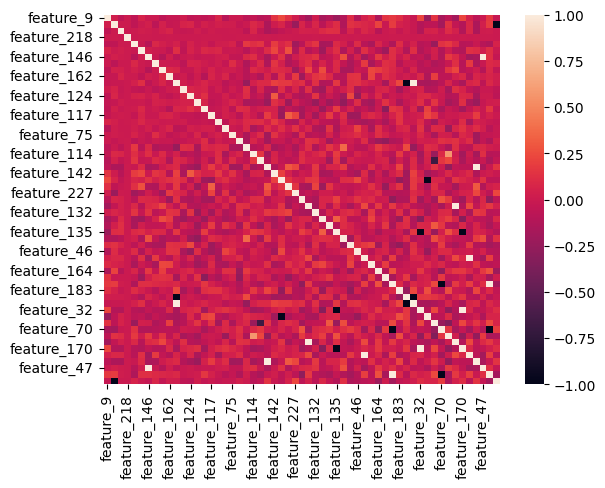

In [23]:
sns.heatmap(df[good_float_features].corr())

In [24]:
cor = df[good_float_features].corr()
mask = np.triu(np.ones_like(cor, dtype=bool))  # верхний треугольник матрицы корреляции, чтобы не дублировать
cor = cor.mask(mask)
cor_pairs = cor[abs(cor) > 0.7].stack().reset_index()
cor_pairs

level_0      level_1    0
0    feature_27  feature_167 -1.0
1     feature_4  feature_167  1.0
2     feature_4   feature_27 -1.0
3    feature_32  feature_135 -1.0
4   feature_206   feature_12 -1.0
5    feature_70   feature_36 -1.0
6    feature_23  feature_155  1.0
7   feature_170  feature_135 -1.0
8   feature_170   feature_32  1.0
9    feature_39  feature_100  1.0
10  feature_216   feature_65  1.0
11   feature_47  feature_146  1.0
12   feature_94   feature_36  1.0
13   feature_94   feature_70 -1.0
14   feature_43   feature_15 -1.0

IV у этих признаков попарно одинаковый

In [25]:
correlates = list(set(cor_pairs.level_1))

In [26]:
good_float_features = good_float_features.difference(correlates)

In [27]:
good_features = good_int_features.append(good_float_features)
good_features.shape

(54,)

# Бустинг

## Подбор гиперпараметров бустинга

Теперь подберем оптимальные гиперпараметры бустинга.

In [28]:
features_optuna = good_features

In [29]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=False),
        'num_leaves': trial.suggest_int('num_leaves', 230, 300),
        # 'importance_type': ['split', 'gain'],
        'objective': 'binary',
        'random_state': 42
    }
    
    clf = LGBMClassifier(**params)
    clf.fit(
        X=df.loc[df['sample_part'] == 'train', features_optuna],
        y=df.loc[df['sample_part'] == 'train', TARGET]
    )
    preds = clf.predict_proba(df.loc[df['sample_part'] == 'val', features_optuna])[:, 1]
    auc_valid = roc_auc_score(
        y_true=df.loc[df['sample_part'] == 'val', TARGET],
        y_score=preds
    )
    
    return auc_valid

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=True)

In [31]:
print(study.best_params)

{'learning_rate': 0.06886345061107325, 'num_leaves': 253}


In [32]:
clf = LGBMClassifier(**study.best_params)
clf.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET]
)

preds_test = clf.predict_proba(df.loc[df['sample_part'] == 'test', features_optuna])[:, 1]
auc_test = roc_auc_score(
    y_true=df.loc[df['sample_part'] == 'test', TARGET],
    y_score=preds_test
)

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11548
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


In [ ]:
# auc_test > 0.725

## Кривые накопления

Отрисуйем кривые накопления `ROC AUC` от `n_estimators` для бустинга с гиперпараметрами из предыдущего пункта.

In [ ]:
aucs = []
for i in range(10, 151, 10):
    clf_for_curve = LGBMClassifier(learning_rate=0.06622014168732689, num_leaves=262, n_estimators=i)
    clf_for_curve.fit(
        X=df.loc[df['sample_part'] == 'train', features_optuna],
        y=df.loc[df['sample_part'] == 'train', TARGET]
    )
    
    preds_test = clf_for_curve.predict_proba(df.loc[df['sample_part'] == 'test', features_optuna])[:, 1]
    auc_test = roc_auc_score(
        y_true=df.loc[df['sample_part'] == 'test', TARGET],
        y_score=preds_test
    )
    aucs.append(auc_test)

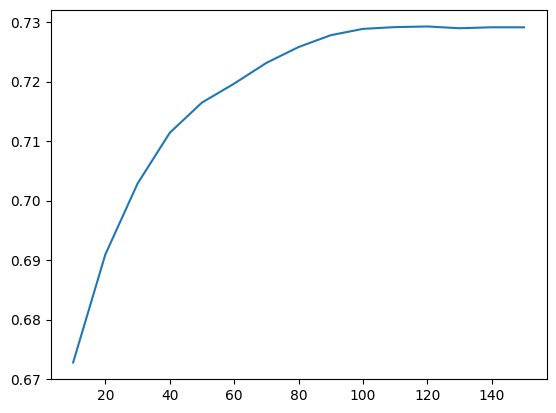

In [34]:
plt.plot(range(10, 151, 10), aucs)

На графике видно, что 100 - оптимальное количество деревьев, т.к. до 100 качество ниже, а после оно не меняется, при том, что модель усложняется.

## Важность признаков

Построем гистограмму важности признаков по `split` и `gain` для бустинга из предыдущего пункта.

In [35]:
split_importance = clf.feature_importances_
gain_importance = clf.booster_.feature_importance(importance_type='gain')

[]

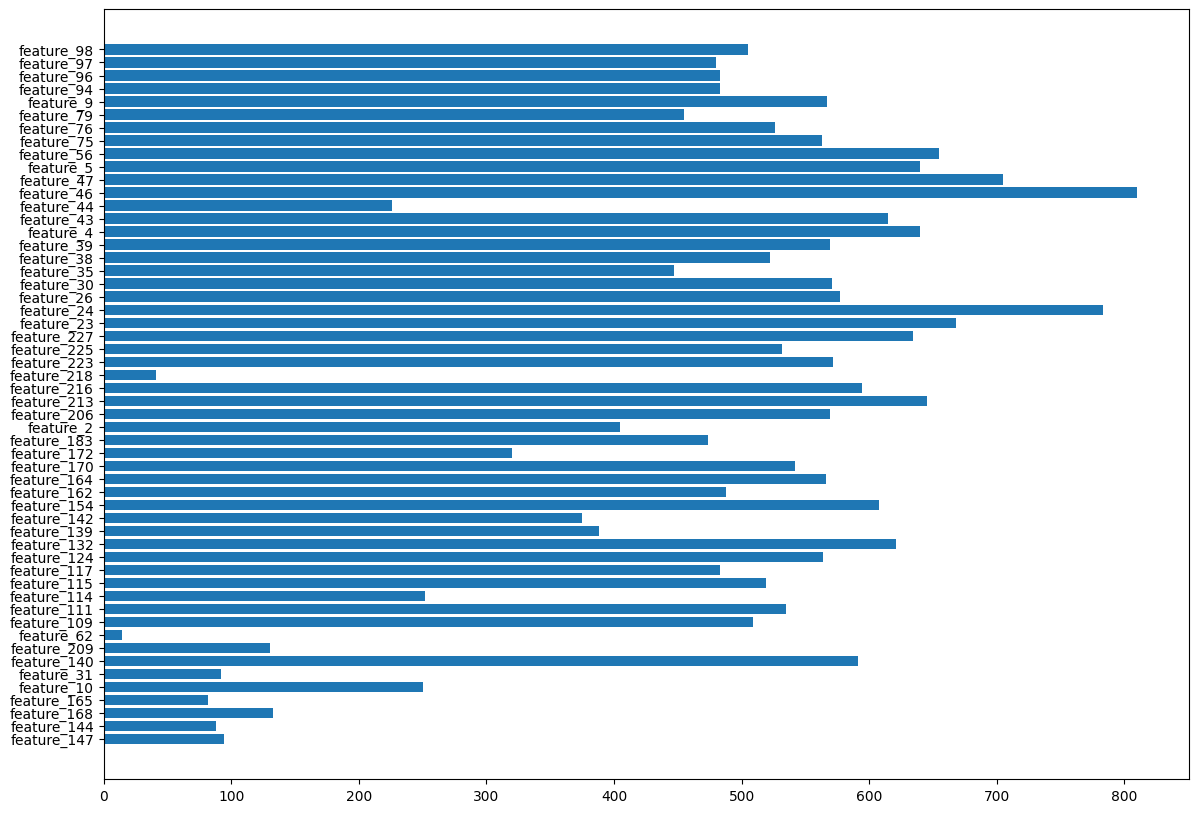

In [36]:
plt.figure(figsize=(14, 10))
plt.barh(range(54), split_importance, align='center')
plt.yticks(range(54), np.array(good_features))
plt.plot()

[]

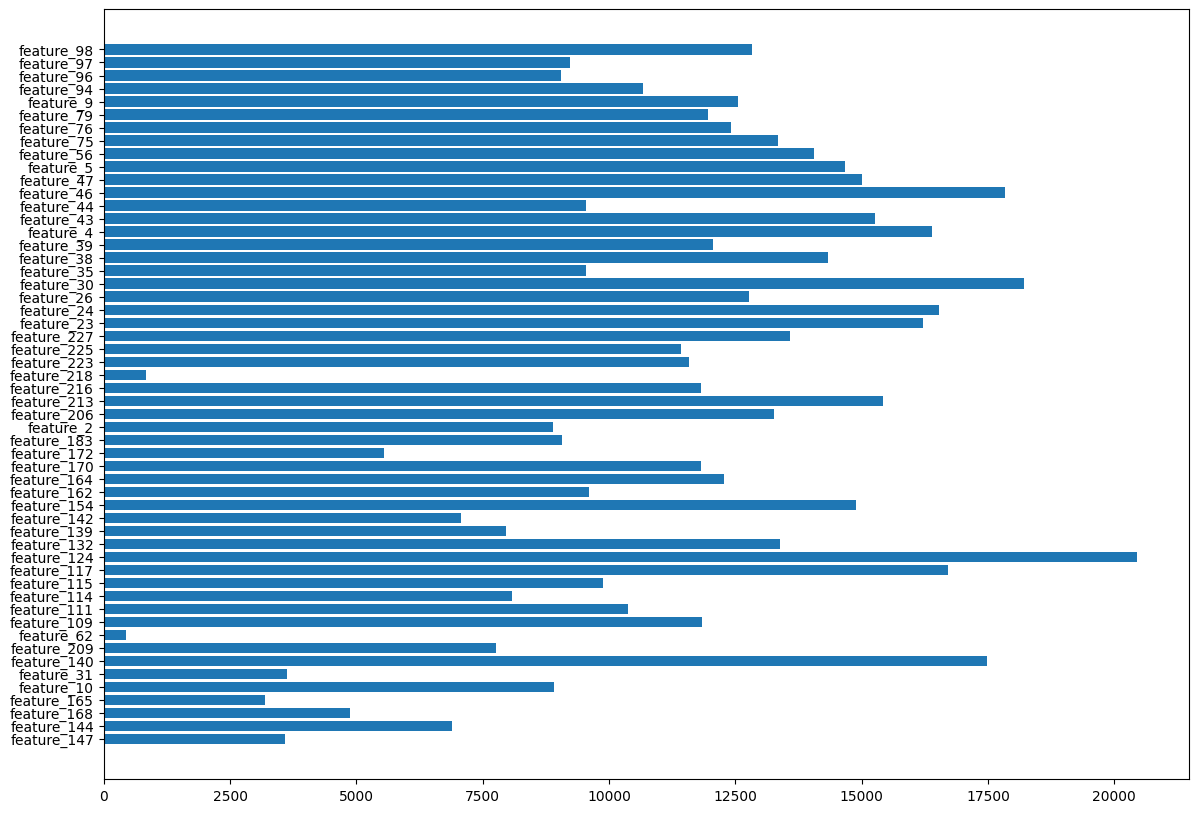

In [37]:
plt.figure(figsize=(14, 10))
plt.barh(range(54), gain_importance, align='center')
plt.yticks(range(54), np.array(good_features))
plt.plot()

Некоторые фичи более важны по split, другие по gain, а 62 и 218 слабо важны и по тому, и по другому.

# Логрег

## plot_metric_time

In [38]:
import plotly.graph_objects as go

In [39]:
def plot_metric_time(
        values: pd.Series,
        target: pd.Series,
        time: pd.Series,
        metric: str = 'IV',
        n_buckets_for_IV: int = 15
) -> go.Figure:

    agg_metric = []
    if metric == 'IV':
        for t in df[time.name].unique():
            mask = (time == t)
            temp_df = pd.DataFrame({'tm': target[mask], 'vm': values[mask]})
            temp_df.dropna(inplace=True)
            buckets = calc_buckets(temp_df.vm, n_buckets_for_IV)
            agg_metric.append(calc_iv(temp_df.vm, temp_df.tm, buckets))
    elif metric == 'roc_auc':
        for t in df[time.name].unique():
            mask = (time == t)
            temp_df = pd.DataFrame({'tm': target[mask], 'vm': values[mask]})
            temp_df.dropna(inplace=True)
            agg_metric.append(roc_auc_score(temp_df.tm, temp_df.vm))
    else:
        raise NotImplementedError("only 'IV' and 'roc_auc' metrics are implemented")

    plot_title = f'Change of {metric} in time for {values.name}'
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x= df[time.name].unique().astype('str'),
            y= agg_metric,
            mode='markers+lines',
            name=values.name
            ))
    fig.update_layout(
            title_text=plot_title,
            yaxis=dict(title=metric),
            width=1000,
            height=450,
            xaxis=dict(
                domain=[0, .95],
                showgrid=True,
                tickvals=df[time.name].unique().astype('str')
                ),
            margin=dict(l=30, r=30, b=30, t=50),
            )
    fig.show()

    # return fig

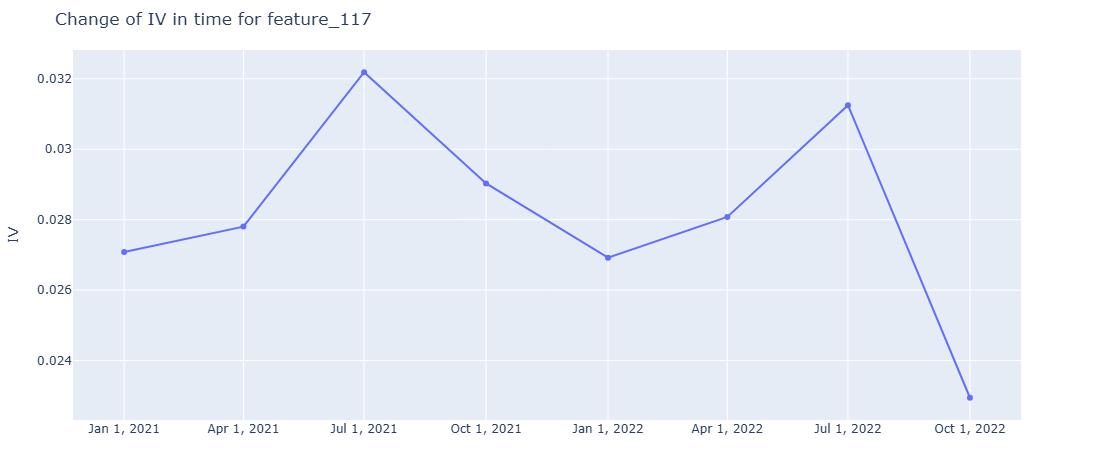

In [40]:
plot_metric_time(df[good_features[13]], df['target'], df['quarter'])

Возьмем **топ-15** фичей получившегося бустинга по важности по `gain`. 

Отрисуем для них графики стабильности по `IV` во времени и удалим из рассмотрения те признаки, качество которых деградирует

In [41]:
top15ind = np.argsort(gain_importance)[::-1][:15]
good_features = good_features[top15ind]
good_features

Index(['feature_124', 'feature_30', 'feature_46', 'feature_140', 'feature_117',
       'feature_24', 'feature_4', 'feature_23', 'feature_213', 'feature_43',
       'feature_47', 'feature_154', 'feature_5', 'feature_38', 'feature_56'],
      dtype='object')

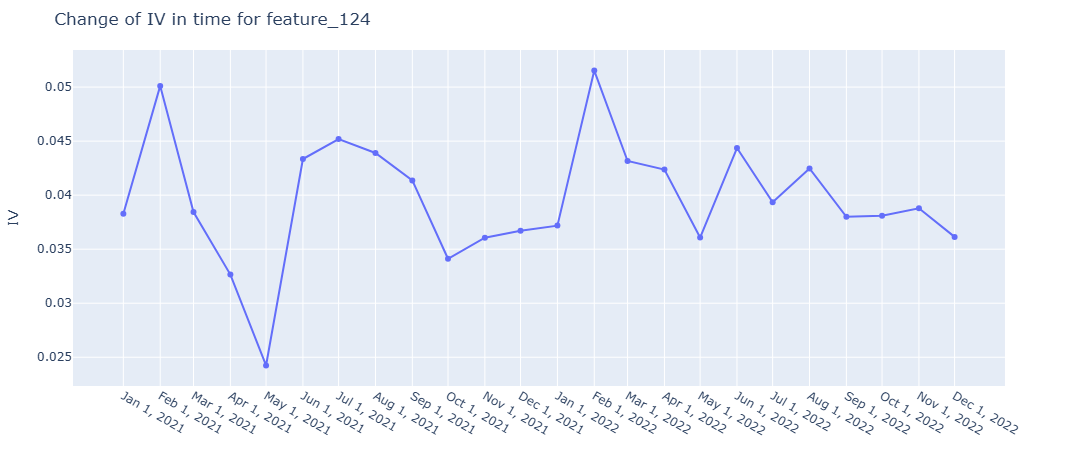

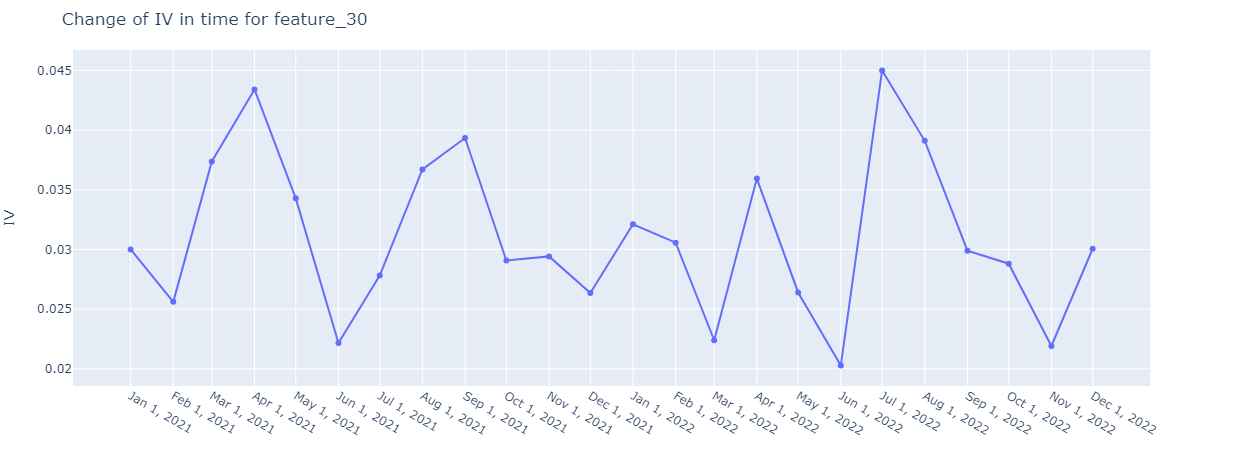

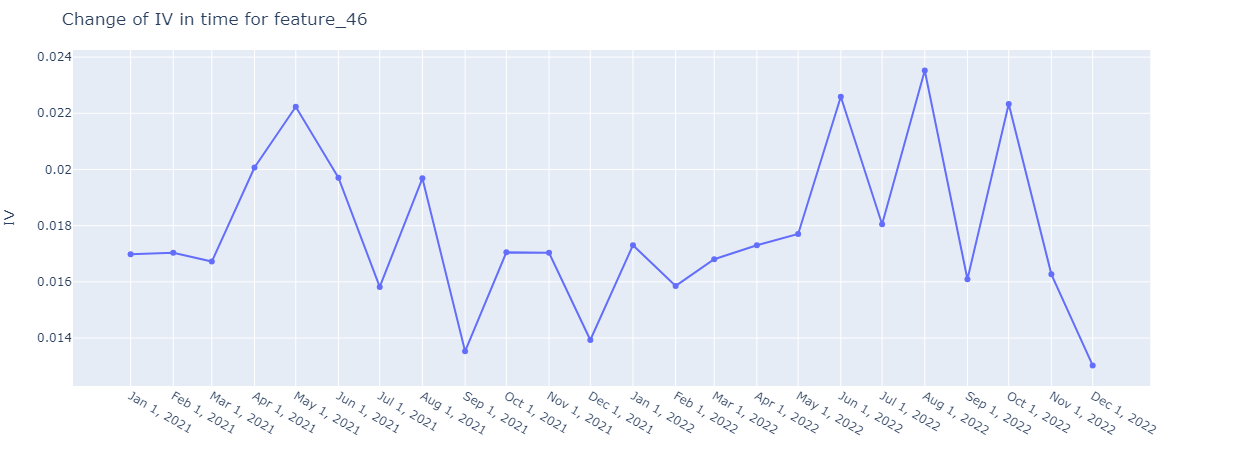

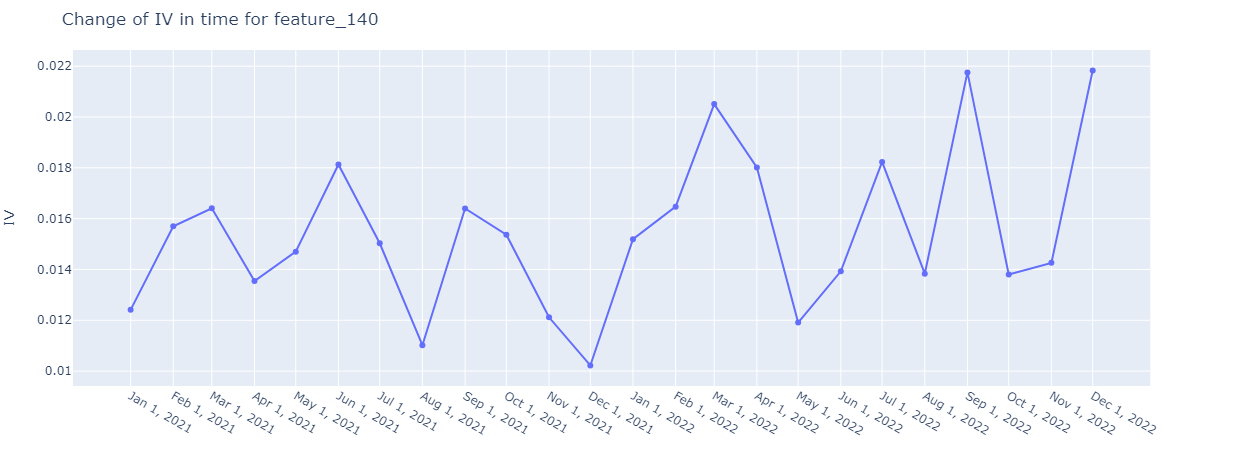

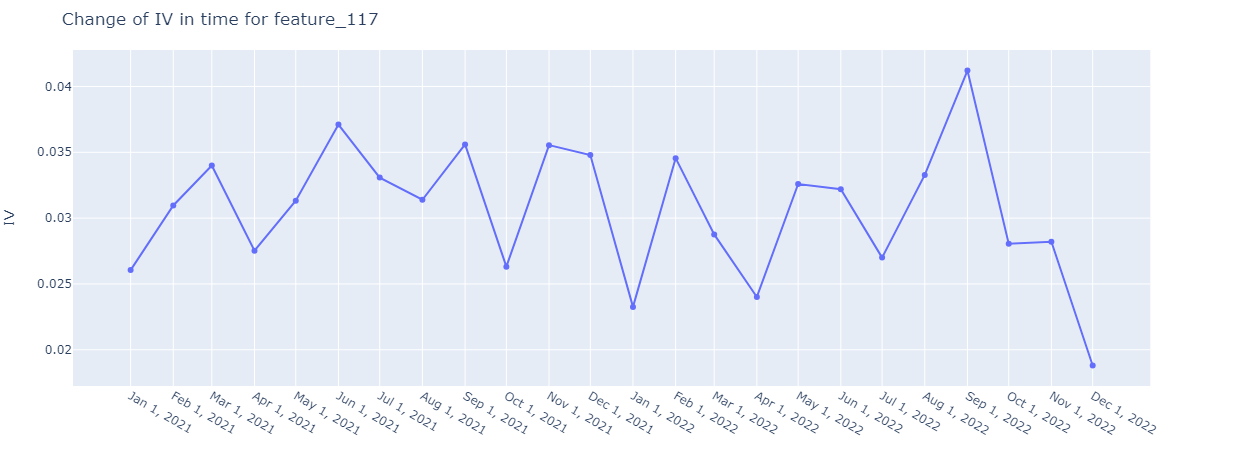

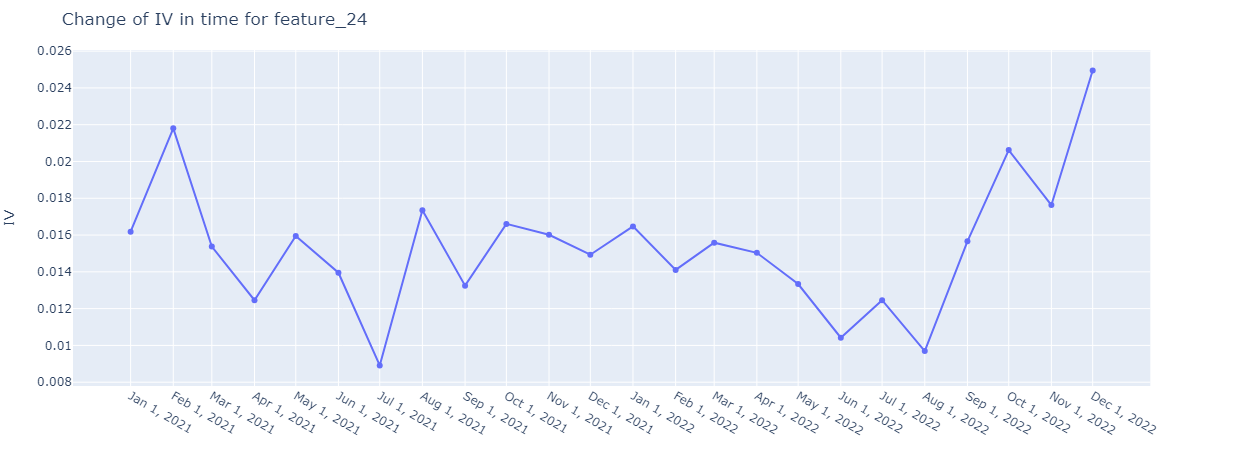

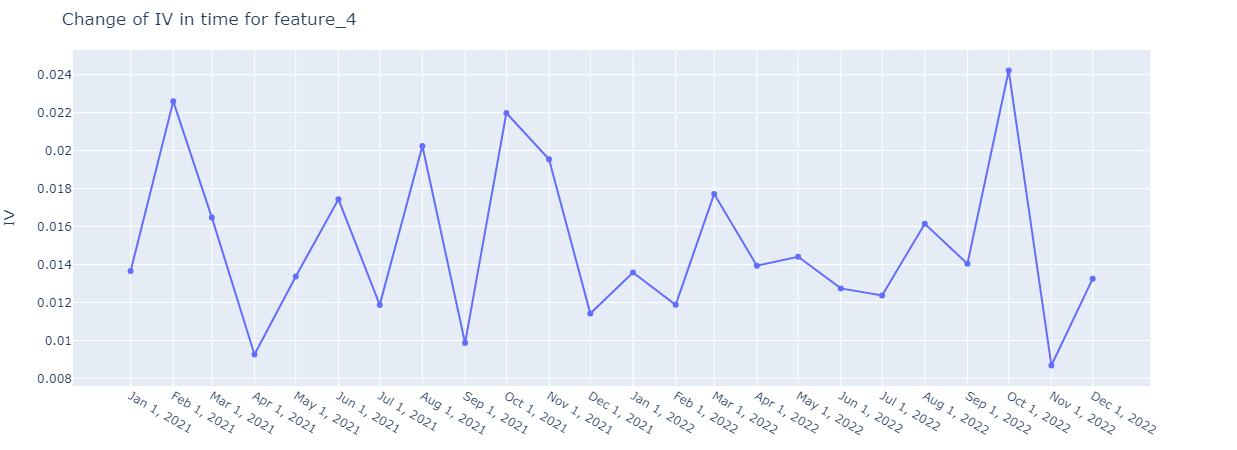

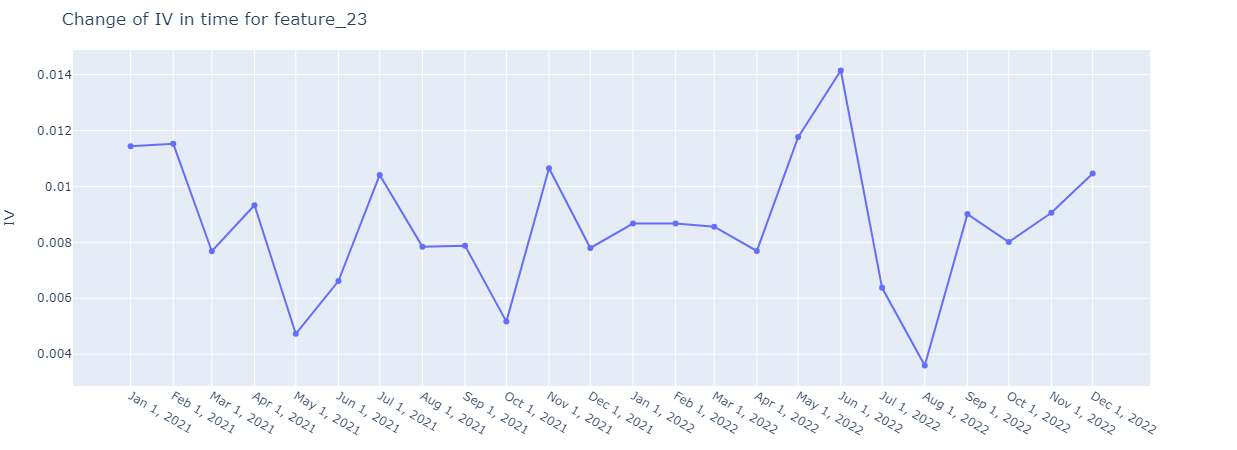

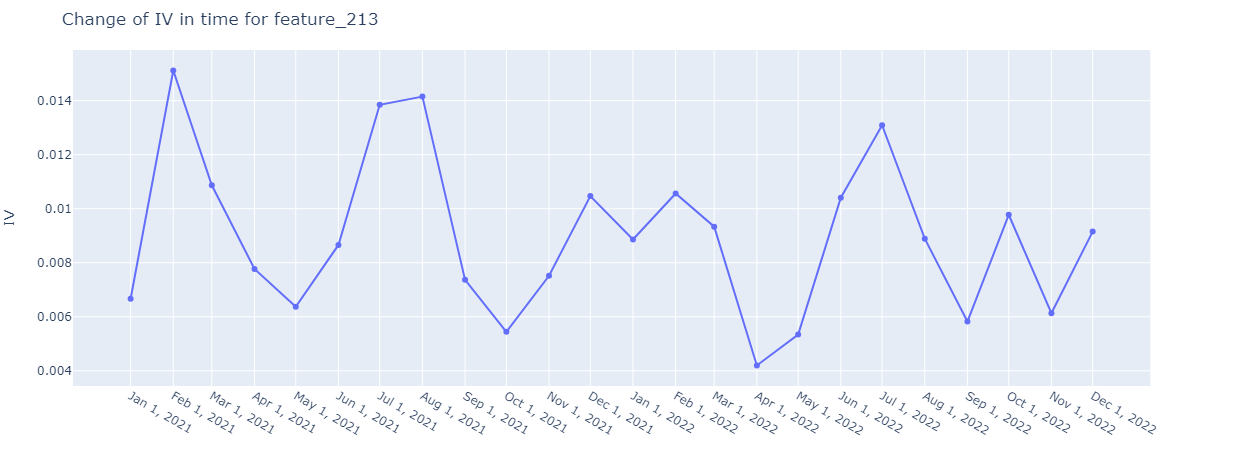

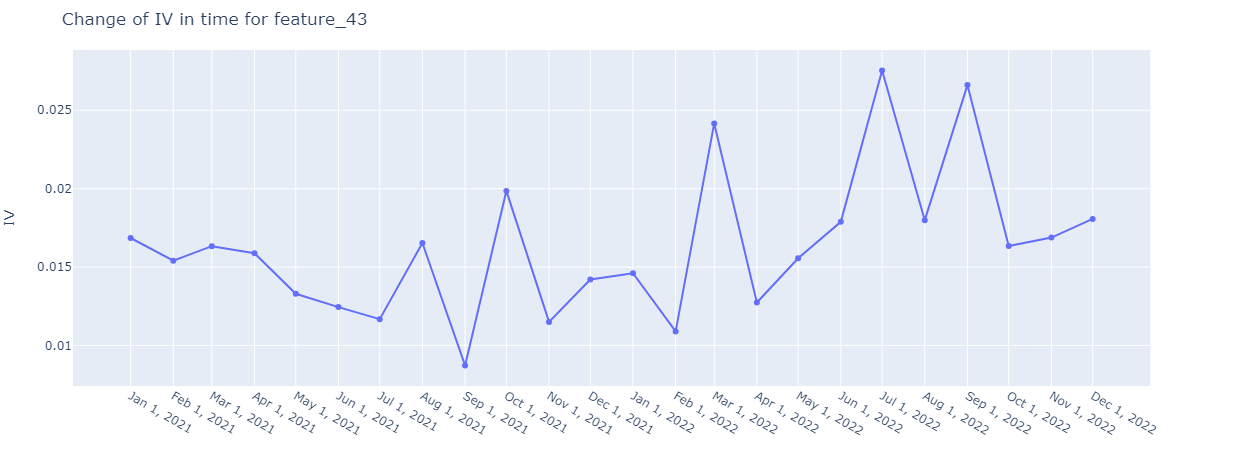

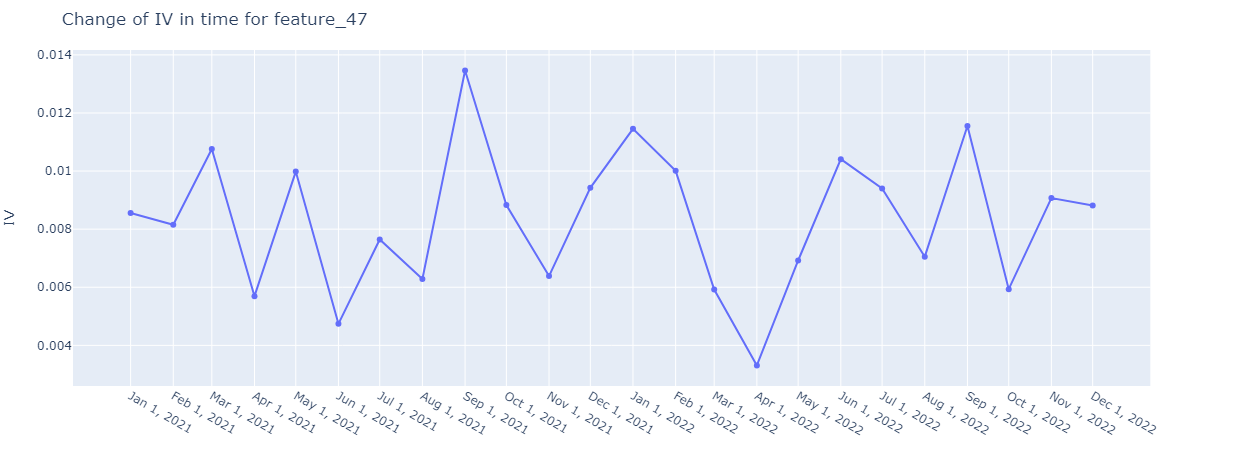

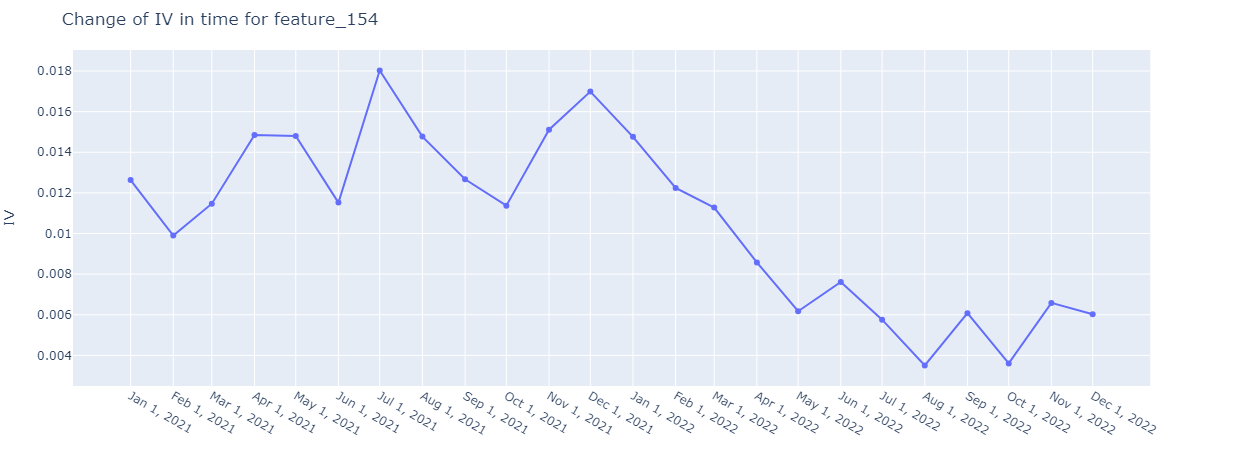

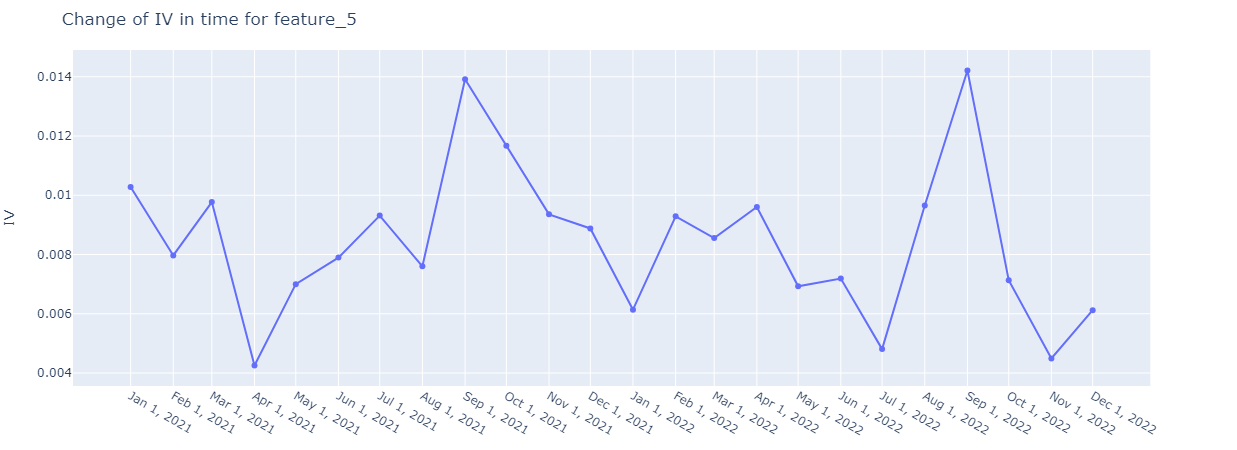

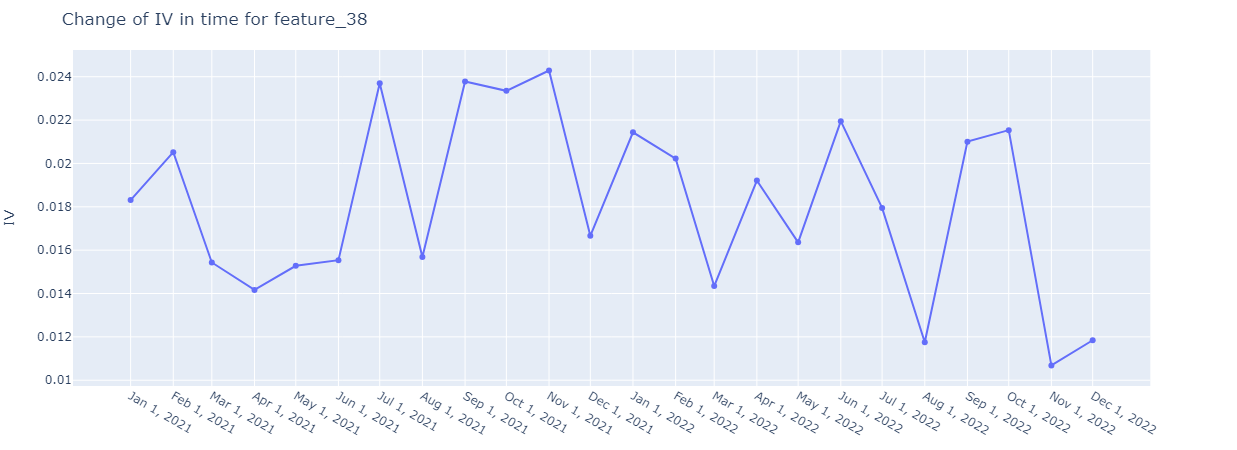

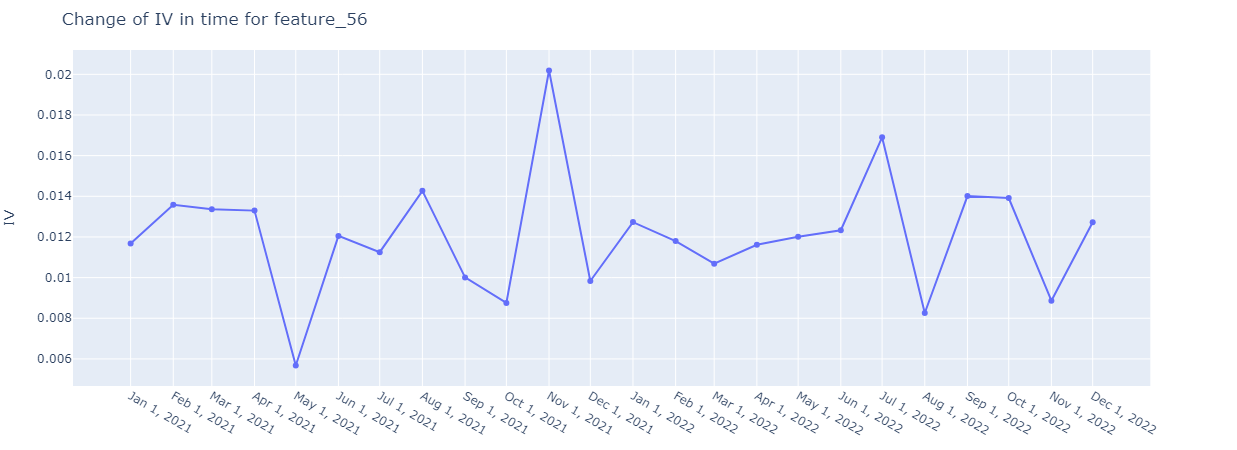

In [42]:
for feature in good_features:
    plot_metric_time(df[feature], df['target'], df['month'], metric='IV')

In [43]:
top15features_stable = good_features.difference(['feature_154'])

На этом моменте сделаю новый маленький датафрейм, чтобы не "портить" исходный

In [44]:
df_for_logreg = df[top15features_stable.append(pd.Index(['date', 'month', 'quarter', 'target', 'sample_part']))]

In [45]:
df_for_logreg.tail(2)

feature_117  feature_124  feature_140  feature_213  feature_23  \
443018   -12.865323   -28.192184           26    10.443730  -49.158919   
310653   -11.315535          NaN         <NA>    14.791296   15.520829   

        feature_24  feature_30  feature_38   feature_4  feature_43  \
443018   -3.723810     0.04306  105.113244 -247.200401  -29.305830   
310653  -18.952444         NaN  131.833319 -196.116171  -37.877501   

        feature_46  feature_47   feature_5  feature_56       date      month  \
443018   -3.294182   50.371585 -139.585458  -41.523991 2022-12-30 2022-12-01   
310653 -127.870862   36.155332 -135.013833  -93.182733 2022-12-30 2022-12-01   

          quarter  target sample_part  
443018 2022-10-01       1        test  
310653 2022-10-01       1        test

In [46]:
df_for_logreg.isna().sum()

feature_117        0
feature_124    58984
feature_140    36943
feature_213        0
feature_23         0
feature_24         0
feature_30     34475
feature_38         0
feature_4          0
feature_43         0
feature_46         0
feature_47         0
feature_5          0
feature_56         0
date               0
month              0
quarter            0
target             0
sample_part        0
dtype: int64

## Предобработка признаков

Используя функицю woe_line, проверим **числовые** фичи из полученного списка фичей на линейность по WoE на трейн-выборке

In [47]:
from scipy import stats

def calculate_badrate(target : np.ndarray, buckets : np.ndarray, p:float = 0.95):
    unique_buckets = np.unique(buckets)
    result = []
    res_lower = []
    res_upper = []
    
    for bucket in unique_buckets:
        mask = (buckets == bucket)
        bad = np.sum(target[mask])
        capacity = np.sum(mask)  # not 0
        badrate = bad / capacity
        result.append(badrate)
        
        mean = np.mean(target[mask])
        std = np.std(target[mask])
        se = std/(capacity)**0.5
        alpha = (1-p)/2
        sigma = stats.norm().isf(alpha)
        lower, upper = mean - sigma*se, mean + sigma*se
        res_lower.append(lower)
        res_upper.append(upper)

    result = np.array(result)
    res_lower = np.array(res_lower)
    res_upper = np.array(res_upper)

    result[result == 0] = 0.001
    result[result == 1] = 0.999

    res_lower[res_lower <= 0] = 0.001
    res_lower[res_lower >= 1] = 0.999

    res_upper[res_upper <= 0] = 0.001
    res_upper[res_upper >= 1] = 0.999
    
    return result, res_lower, res_upper

def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float) -> Tuple[pd.Series]:
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""
    # считаем бэдрейт и доверительный интервал для него (любым способом)
    
    badrate, badrate_lower, badrate_upper = calculate_badrate(target, buckets)
    
    # переходим от бэдрейта к woe
    woe, woe_lower, woe_upper = woe_transform(badrate, offset), woe_transform(badrate_lower, offset), woe_transform(badrate_upper, offset)
    
    return woe, woe_lower, woe_upper

from sklearn.linear_model import LogisticRegression

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""

    # строим логистическую регрессию на одном признаке
    # и считаем ее предсказания в точках – mean_feature
    values = values.reshape((values.shape[0], 1))
    mean_feature = mean_feature.reshape((mean_feature.shape[0], 1))
    clf = LogisticRegression().fit(values, target)
    proba = clf.predict_proba(mean_feature)[:,1]
    line = woe_transform(proba, offset)
    return line

def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""
    
    buckets_info = {
        "mean_feature" : [],
        "line"         : [],
        "woe"          : [],
        "woe_lower"    : [],
        "woe_upper"    : []
    }
    offset = logit(sum(target) / len(target))
    woe, woe_lower, woe_upper = woe_ci(target, buckets, offset)
    buckets_info["woe"] = woe
    buckets_info["woe_lower"] = woe_lower
    buckets_info["woe_upper"] = woe_upper
    
    unique_buckets = np.unique(buckets)
    for bucket in unique_buckets:
        mask = (buckets == bucket)
        mean = np.mean(values[mask])
        buckets_info["mean_feature"].append(mean)
    buckets_info["line"] = calc_line(values, target, np.array(buckets_info["mean_feature"]), offset)
    
    return buckets_info

def calc_plot_title(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""

    unique_buckets, cap_b = np.unique(buckets, return_counts=True)
    offset = logit(sum(target) / len(target))

    # формула выше
    auc = 0
    IV = 0
    B = np.sum(target)
    G = len(target) - B

    mean_b = []
    woe_b = []
    
    for bucket in unique_buckets:
        mask = (buckets == bucket)
        capacity = np.sum(mask)  # not 0
        bad = np.sum(target[mask])
        badrate = bad / capacity
        woe = woe_transform(badrate, offset)
        
        mean_b.append(np.mean(values[mask]))
        woe_b.append(woe)
        
        IV += (bad/B - (len(target[mask]) - bad)/G) * woe
        
    auc = roc_auc_score(target, values)
    
    R_sqr = r2_score(woe_b, calc_line(values, target, np.array(mean_b), offset), sample_weight=cap_b)

    plot_title = (        
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title

def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig

def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : pd.DataFrame = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets)
    fig = make_figure(buckets_info, plot_title)
    return fig

In [48]:
n = df_for_logreg.shape[0]

In [49]:
df_for_logreg.columns

Index(['feature_117', 'feature_124', 'feature_140', 'feature_213',
       'feature_23', 'feature_24', 'feature_30', 'feature_38', 'feature_4',
       'feature_43', 'feature_46', 'feature_47', 'feature_5', 'feature_56',
       'date', 'month', 'quarter', 'target', 'sample_part'],
      dtype='object')

In [50]:
pd.options.mode.chained_assignment = None 

In [51]:
(df_for_logreg.feature_124 > -25).sum()

30991

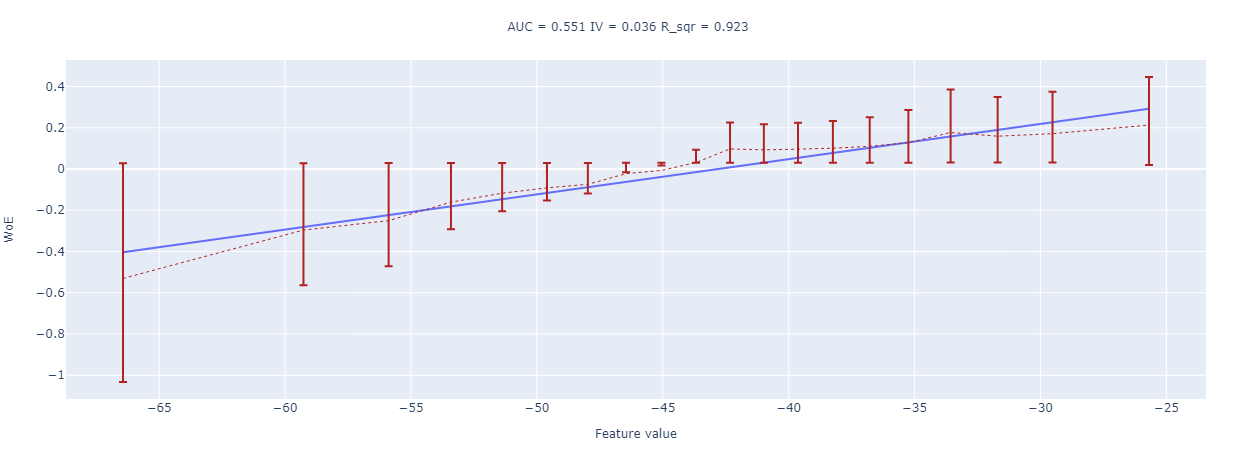

In [52]:
woe_line(np.array(df_for_logreg.dropna().feature_124.clip(upper=-25)), df_for_logreg.dropna().target, 20)

In [53]:
df_for_logreg.feature_124 = df_for_logreg.feature_124.clip(upper=-25)

In [54]:
(df_for_logreg.feature_140 < 1).sum()

1923

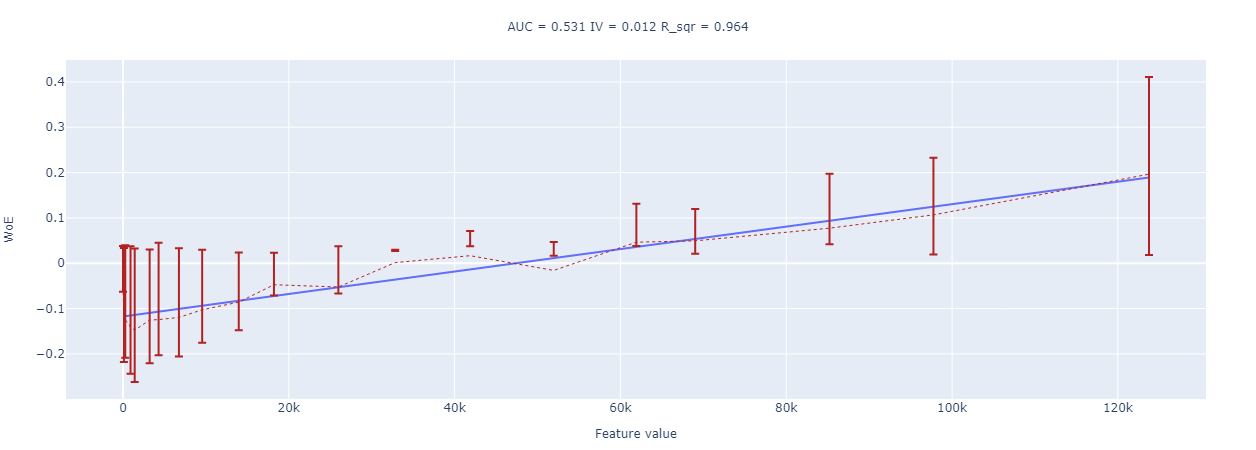

In [55]:
woe_line(np.array((df_for_logreg.dropna().feature_140.clip(lower=1))**3), df_for_logreg.dropna().target, 20)

In [56]:
df_for_logreg.feature_140 = (df_for_logreg.feature_140.clip(lower=1))**3

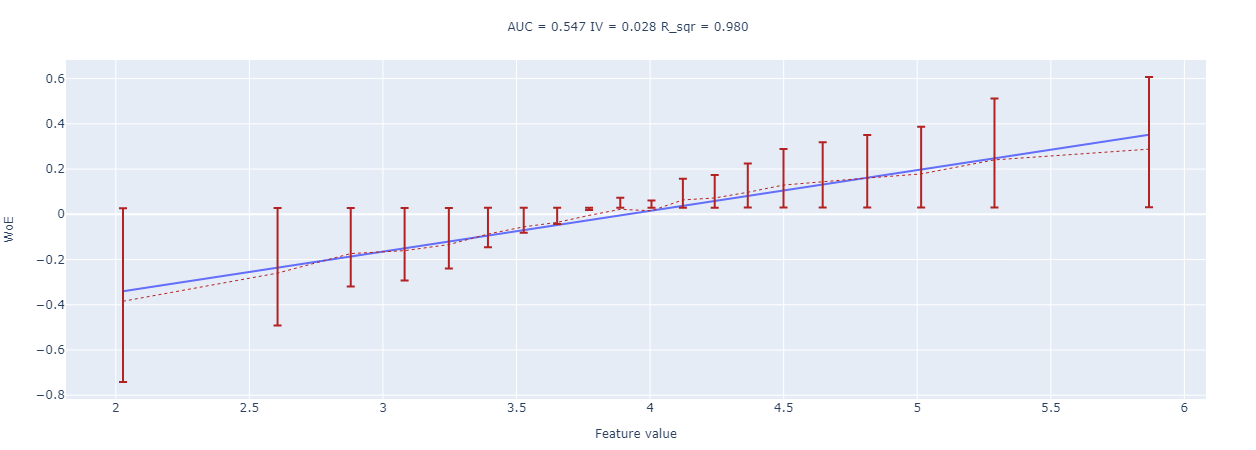

In [57]:
woe_line(np.array(np.log(1/(df_for_logreg.dropna().feature_30))), df_for_logreg.dropna().target, 20)

In [58]:
df_for_logreg.feature_30 = np.log(1/(df_for_logreg.dropna().feature_30))

In [59]:
(df_for_logreg.feature_213 < 2.5).sum()

1556

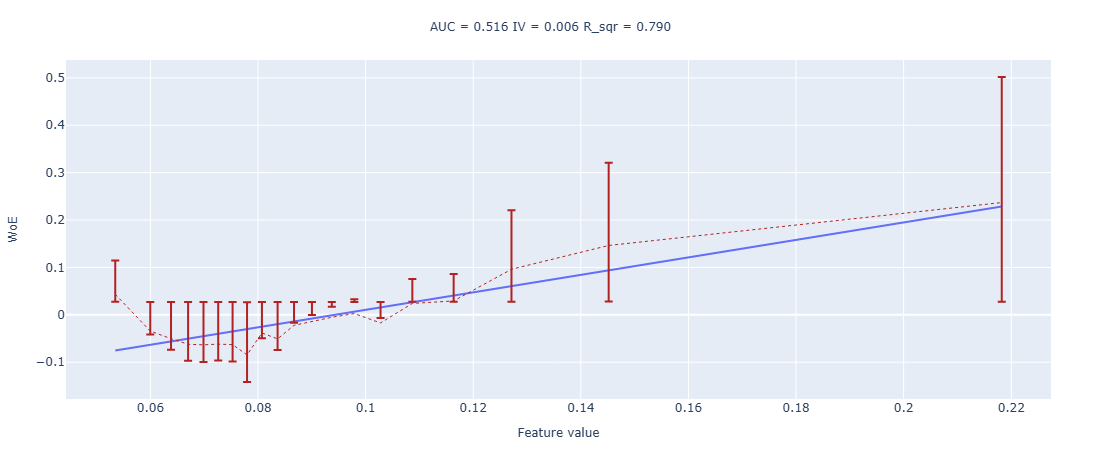

In [60]:
woe_line(np.array(1/(df_for_logreg.feature_213.clip(lower=2.5))), df_for_logreg.target, 20)

In [61]:
df_for_logreg.feature_213 = 1/(df_for_logreg.feature_213.clip(lower=2.5))

In [62]:
(df_for_logreg.feature_23 > 150).sum()

8011

In [63]:
df_for_logreg.feature_23.describe()

count    500000.000000
mean        -24.793038
std          81.960269
min        -448.656230
25%         -79.144640
50%         -24.148417
75%          30.137979
max         385.240030
Name: feature_23, dtype: float64

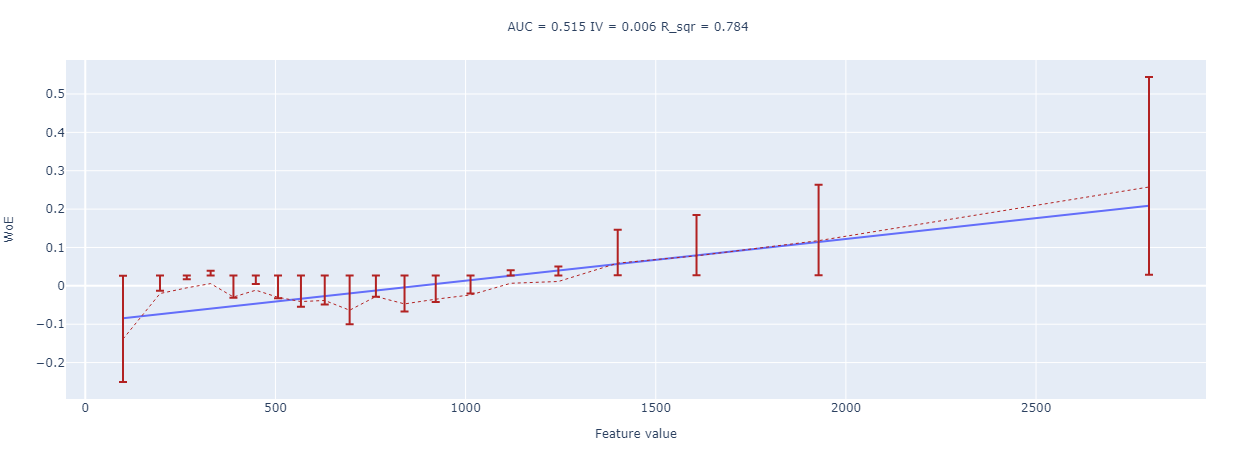

In [64]:
woe_line(np.array((((df_for_logreg.feature_23 + 450)/np.std(df_for_logreg.feature_23))**4)), df_for_logreg.target, 20)

In [65]:
df_for_logreg.feature_23 = ((df_for_logreg.feature_23 + 450)/np.std(df_for_logreg.feature_23))**4

In [66]:
(df_for_logreg.feature_38 < 20).sum()

1128

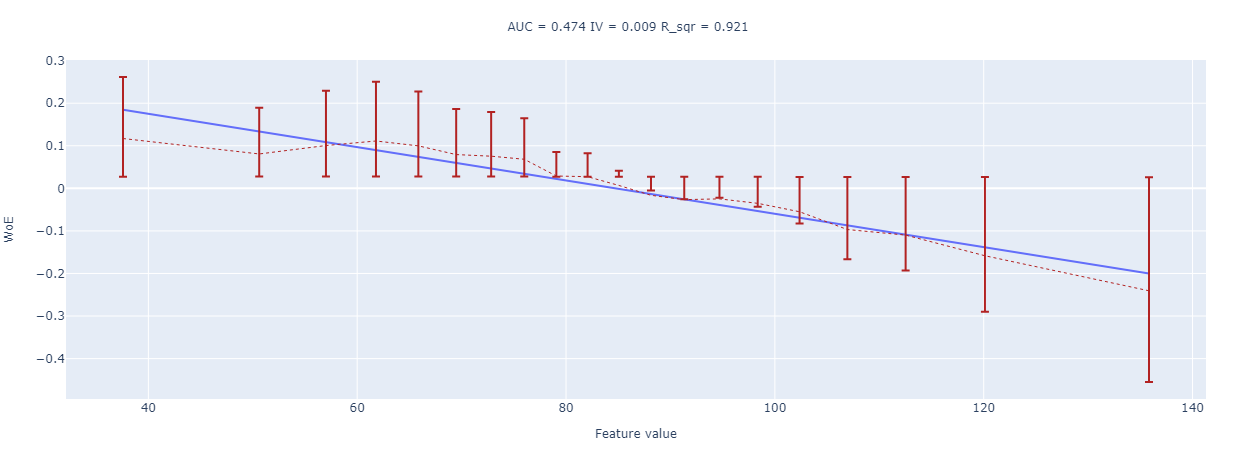

In [67]:
woe_line(np.array((df_for_logreg.feature_38.clip(lower=20))), df_for_logreg.target, 20)

In [68]:
df_for_logreg.feature_38 = df_for_logreg.feature_38.clip(lower=20)

In [69]:
(df_for_logreg.feature_46 < -400).sum()

5748

In [70]:
((np.log((-df_for_logreg.feature_46 + 1100))**0.4) > 2.22).sum()

3167

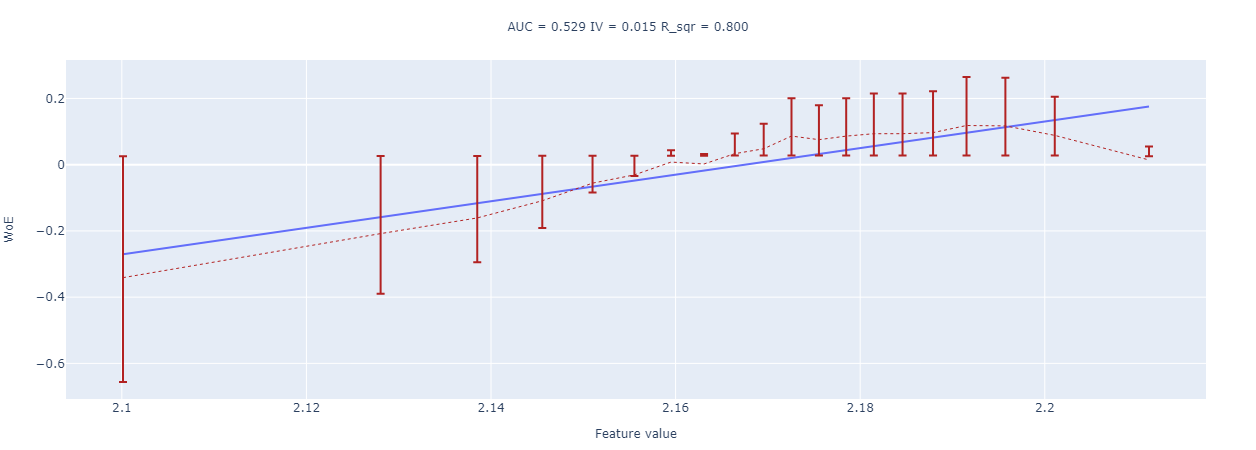

In [71]:
woe_line(np.array((np.log((-df_for_logreg.feature_46 + 1100))**0.4).clip(upper=2.22)), df_for_logreg.target, 20)

In [72]:
df_for_logreg.feature_46 = (np.log((-df_for_logreg.feature_46 + 1100))**0.4).clip(upper=2.22)

In [73]:
((np.log(-df_for_logreg.feature_47 + 140)**0.2) > 1.385).sum()

1225

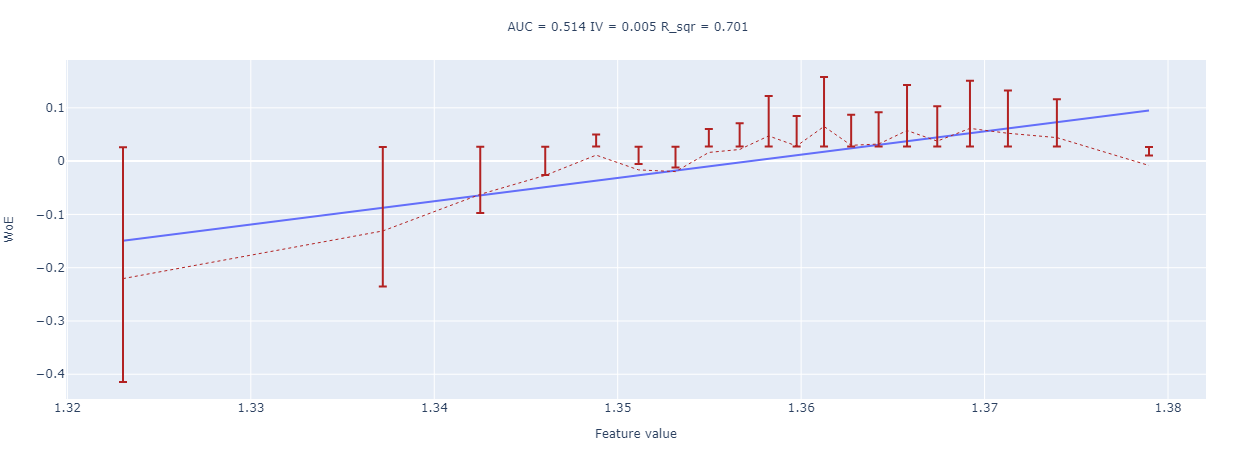

In [74]:
woe_line(np.array((np.log(-df_for_logreg.feature_47 + 140)**0.2).clip(upper=1.385)), df_for_logreg.target, 20)

In [75]:
df_for_logreg.feature_47 = (np.log(-df_for_logreg.feature_47 + 140)**0.2).clip(upper=1.385)

In [76]:
(1/((-df_for_logreg.feature_5 + 35)**0.06) < 0.71).sum()

2795

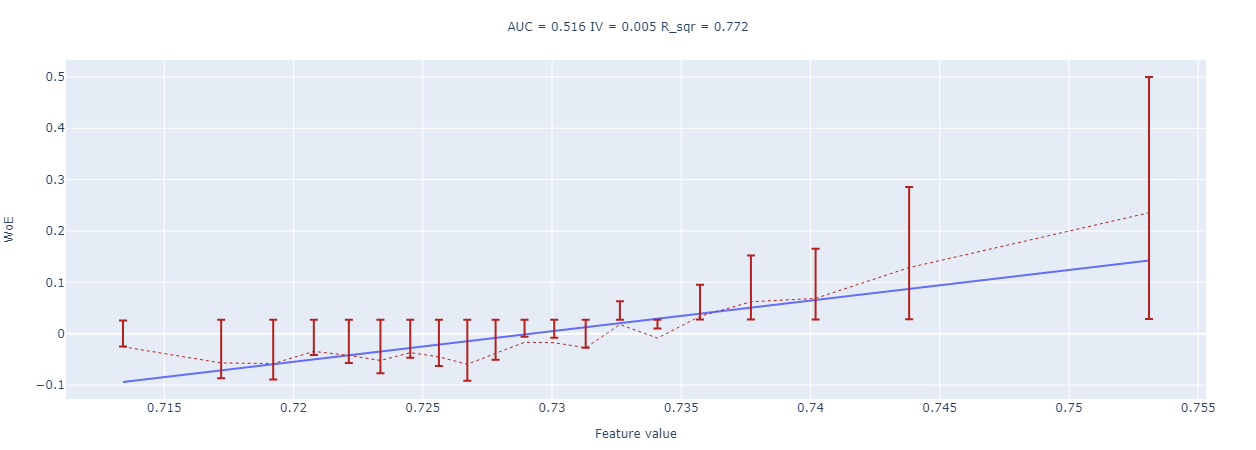

In [77]:
woe_line(np.array((1/((-df_for_logreg.feature_5 + 35)**0.06)).clip(lower=0.71)), df_for_logreg.target, 20)

In [78]:
df_for_logreg.feature_5 = (1/((-df_for_logreg.feature_5 + 35)**0.06)).clip(lower=0.71)

In [79]:
# df_for_logreg = df_for_logreg.drop(['feature_47', 'feature_5', 'feature_23', 'feature_213'], axis=1)

С линеаризацией не очень получилось, но если удалять фичи с R < 0.8, то модель становится хуже.

In [80]:
df_for_logreg.columns

Index(['feature_117', 'feature_124', 'feature_140', 'feature_213',
       'feature_23', 'feature_24', 'feature_30', 'feature_38', 'feature_4',
       'feature_43', 'feature_46', 'feature_47', 'feature_5', 'feature_56',
       'date', 'month', 'quarter', 'target', 'sample_part'],
      dtype='object')

Пришло время заполнить пропуски.

Среднее - не самая репрезентативная статистика для выборки. Часто лучше брать среднее/медиану по неким логическим группам, но в нашем случае столбцы анонимизированы, поэтому особо нет лучше вариантов, кроме как взять среднее/медиану.
Иногда можно еще брать моду.

In [81]:
df_for_logreg.isna().sum()[df_for_logreg.isna().sum() > 0]

feature_124    58984
feature_140    36943
feature_30     58984
dtype: int64

<Axes: >

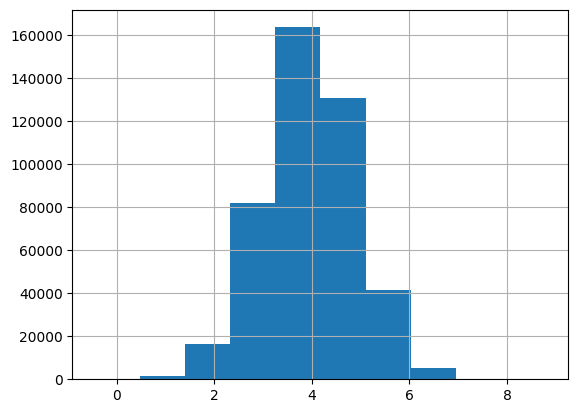

In [82]:
df_for_logreg.feature_30.hist()

In [83]:
# можно заполнить средним

<Axes: >

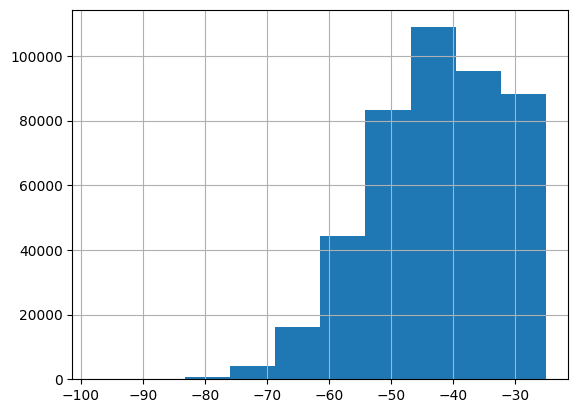

In [84]:
df_for_logreg.feature_124.hist()

In [85]:
# можно заполнить медианой

In [86]:
df_for_logreg.feature_140.value_counts()  

feature_140
97336     53497
68921     46071
125000    41893
17576     28880
32768     19227
117649    17809
3375      17380
9261      16613
125       14592
15625     14407
1331      13537
12167     12804
85184     11160
42875     10002
1000       9108
27000      8096
5832       7919
8          7612
64000      7571
4096       6839
132651     6356
216        6042
59319      5995
13824      5715
343        5636
1          5569
8000       5492
24389      5186
54872      4642
10648      4441
35937      4148
21952      4108
39304      3926
29791      3804
729        3741
6859       3727
1728       3660
2197       2629
4913       2254
46656      2079
19683      2001
50653      1972
110592     1254
103823     1020
27          947
64          903
79507       320
74088       211
512         153
91125        66
2744         43
Name: count, dtype: Int64

In [87]:
# здесь подойдет мода

In [88]:
print(np.mean(df_for_logreg.feature_30))
df_for_logreg.feature_30 = df_for_logreg.feature_30.fillna(value=np.mean(df_for_logreg.feature_30))

3.946831226676876


In [89]:
print(np.median(df_for_logreg.feature_124.dropna()))
df_for_logreg.feature_124 = df_for_logreg.feature_124.fillna(value=np.median(df_for_logreg.feature_124.dropna()))

-41.98530580571869


In [90]:
df_for_logreg.feature_140 = df_for_logreg.feature_140.fillna(value=46)

Вспомним про категориальные признаки, их нужно закодировать.

In [91]:
from sklearn.preprocessing import OneHotEncoder

In [92]:
pd.get_dummies(df_for_logreg.feature_140, prefix='cat')

cat_1  cat_8  cat_27  cat_46  cat_64  cat_125  cat_216  cat_343  \
22620   False  False   False   False   False    False    False    False   
478621  False  False   False   False   False    False    False    False   
372254  False  False   False   False   False    False    False    False   
2596    False  False   False   False   False    False    False    False   
216892  False  False   False   False   False    False    False    False   
...       ...    ...     ...     ...     ...      ...      ...      ...   
196513  False  False   False   False   False    False    False    False   
108604  False  False   False   False   False    False    False    False   
141359  False  False   False   False   False    False    False    False   
443018  False  False   False   False   False    False    False    False   
310653  False  False   False    True   False    False    False    False   

        cat_512  cat_729  ...  cat_74088  cat_79507  cat_85184  cat_91125  \
22620     False    False  ...      False      False      False      False   
478621    False    False  ...      False      False      False      False   
372254    False    False  ...      False      False      False      False   
2596      False    False  ...      False      False      False      False   
216892    False    False  ...      False      False      False      False   
...         ...      ...  ...        ...        ...        ...        ...   
196513    False    False  ...      False      False      False      False   
108604    False    False  ...      False      False      False      False   
141359    False    False  ...      False      False      False      False   
443018    False    False  ...      False      False      False      False   
310653    False    False  ...      False      False      False      False   

        cat_97336  cat_103823  cat_110592  cat_117649  cat_125000  cat_132651  
22620       False       False       False       False       False       False  
478621      False       False       False       False       False       False  
372254      False       False       False       False       False       False  
2596        False       False       False       False       False       False  
216892      False       False       False       False        True       False  
...           ...         ...         ...         ...         ...         ...  
196513      False       False       False       False       False       False  
108604      False       False       False       False        True       False  
141359       True       False       False       False       False       False  
443018      False       False       False       False       False       False  
310653      False       False       False       False       False       False  

[500000 rows x 52 columns]

In [93]:
df_for_logreg = pd.merge(df_for_logreg, pd.get_dummies(df_for_logreg.feature_140, prefix='cat'), left_index=True, right_index=True)

In [94]:
df_for_logreg.drop(['feature_140'], axis=1, inplace=True)

## Stepwise и обучение логрега

Реализуем Stepwise-алгоритм.

In [95]:
from scipy.stats.distributions import chi2
from sklearn.metrics import log_loss

In [96]:
def likelihood_ratio_test(ll_short, ll_long):
    
    """
    вспомогательная функция
    рассчитывает значение p-value для теста отношения правдоподобия
    ll_short — логарифм правдоподобия модели на k переменных
    ll_long — логарифм правдоподобия модели на k+1 переменной

    Returns
    -----
    p-value
    """
    lr = -2 * (ll_short - ll_long)
    return chi2.sf(lr, 1)

In [97]:
def stepwise(
        df: pd.DataFrame,
        features: list[str],
        target: str,
        alpha_in: float = 0.01,
        alpha_out: float = 0.05
        ) -> list[str]:

    selected_features = list()

    df = df[features + ['sample_part', target]].copy()

    # шкалируем полностью, чтобы не перегружать и так долгий алгоритм
    sc = MinMaxScaler()
    scdf = pd.DataFrame(sc.fit_transform(df[features]), columns=features)
    df = scdf.merge(df[['sample_part', target]], left_index=True, right_index=True)
    
    model = LogisticRegression()

    while True:
        best_feature = None
        if len(selected_features) < len(features):
            best_p_value = alpha_in

            df_selected = df[selected_features + ['sample_part', target]]
            X_selected_train = df_selected[df_selected.sample_part == 'train'].drop(['sample_part', target], axis=1)
            y_selected_train = df_selected[df_selected.sample_part == 'train'][target]
            X_selected_test = df_selected[df_selected.sample_part == 'test'].drop(['sample_part', target], axis=1)
            y_selected_test = df_selected[df_selected.sample_part == 'test'][target]

            if len(selected_features):
                model.fit(X_selected_train, y_selected_train)
                ll_short = -log_loss(y_selected_test, model.predict_proba(X_selected_test)[:, 1], normalize=False)
            else:
                model.fit(np.ones((y_selected_train.shape[0], 1)), y_selected_train)
                ll_short = -log_loss(y_selected_test, model.predict_proba(np.ones((y_selected_test.shape[0], 1)))[:, 1], normalize=False)

            for feature in features:
                if feature not in selected_features:
                    df_extended = df[selected_features + [feature, 'sample_part', target]]
                    X_extended_train = df_extended[df_extended.sample_part == 'train'].drop(['sample_part', target], axis=1)
                    y_extended_train = df_extended[df_extended.sample_part == 'train'][target]
                    X_extended_test = df_extended[df_extended.sample_part == 'test'].drop(['sample_part', target], axis=1)
                    y_extended_test = df_extended[df_extended.sample_part == 'test'][target]

                    model.fit(X_extended_train, y_extended_train)
                    ll_long = -log_loss(y_extended_test, model.predict_proba(X_extended_test)[:, 1], normalize=False)

                    p_value = likelihood_ratio_test(ll_short, ll_long)
                    # print(f'forward ({feature}): {ll_short, ll_long, p_value}')

                    if p_value < best_p_value:
                        best_p_value = p_value
                        best_feature = feature

            if best_feature:
                selected_features.append(best_feature)
                print(f"В модель была добавлена переменная {best_feature}, p-value: {round(best_p_value, 6)}")
            print(f'forward finished: {selected_features}')

        worst_feature = None
        if len(selected_features) != 1:
            worst_p_value = alpha_out

            df_selected = df[selected_features + ['sample_part', target]]
            X_selected_train = df_selected[df_selected.sample_part == 'train'].drop(['sample_part', target], axis=1)
            y_selected_train = df_selected[df_selected.sample_part == 'train'][target]
            X_selected_test = df_selected[df_selected.sample_part == 'test'].drop(['sample_part', target], axis=1)
            y_selected_test = df_selected[df_selected.sample_part == 'test'][target]
            
            model.fit(X_selected_train, y_selected_train)
            ll_long = -log_loss(y_selected_test, model.predict_proba(X_selected_test)[:, 1], normalize=False)

            for feature in selected_features:
                df_reduced = df[list(set(selected_features) - set([feature])) + ['sample_part', target]]
                X_reduced_train = df_reduced[df_reduced.sample_part == 'train'].drop(['sample_part', target], axis=1)
                y_reduced_train = df_reduced[df_reduced.sample_part == 'train'][target]
                X_reduced_test = df_reduced[df_reduced.sample_part == 'test'].drop(['sample_part', target], axis=1)
                y_reduced_test = df_reduced[df_reduced.sample_part == 'test'][target]
                
                model.fit(X_reduced_train, y_reduced_train)
                ll_short = -log_loss(y_reduced_test, model.predict_proba(X_reduced_test)[:, 1], normalize=False)

                p_value = likelihood_ratio_test(ll_short, ll_long)
                # print(f'backward ({feature}): {ll_short, ll_long, p_value}')

                if p_value > worst_p_value:
                    worst_p_value = p_value
                    worst_feature = feature

            if worst_feature:
                selected_features.remove(worst_feature)
                print(f"Из модели была удалена переменная {worst_feature}, p-value: {round(worst_p_value, 6)}")
            print(f'backward finished: {selected_features} \n')

        if not (best_feature or worst_feature):
            break

    return selected_features

In [98]:
cols = list(df_for_logreg.columns.difference(['date', 'month', 'quarter', 'target', 'sample_part']))

In [99]:
selected_features = stepwise(df_for_logreg, cols, 'target', alpha_in = 0.01, alpha_out = 0.02)

В модель была добавлена переменная feature_38, p-value: 0.0
forward finished: ['feature_38']
В модель была добавлена переменная feature_124, p-value: 0.005613
forward finished: ['feature_38', 'feature_124']
backward finished: ['feature_38', 'feature_124'] 

В модель была добавлена переменная feature_46, p-value: 0.00117
forward finished: ['feature_38', 'feature_124', 'feature_46']
backward finished: ['feature_38', 'feature_124', 'feature_46'] 

forward finished: ['feature_38', 'feature_124', 'feature_46']
backward finished: ['feature_38', 'feature_124', 'feature_46'] 



In [100]:
# оставляет совсем мало фичей с alpha_in = 0.01 и alpha_out = 0.02, хватает на аук 0.55

In [101]:
# stepwise(df, ['feature_154', 'feature_38'], 'target', alpha_in = 0.01, alpha_out = 0.02)

На получившемся наборе признаков обучим логрег

In [102]:
df_for_logreg.columns

Index(['feature_117', 'feature_124', 'feature_213', 'feature_23', 'feature_24',
       'feature_30', 'feature_38', 'feature_4', 'feature_43', 'feature_46',
       'feature_47', 'feature_5', 'feature_56', 'date', 'month', 'quarter',
       'target', 'sample_part', 'cat_1', 'cat_8', 'cat_27', 'cat_46', 'cat_64',
       'cat_125', 'cat_216', 'cat_343', 'cat_512', 'cat_729', 'cat_1000',
       'cat_1331', 'cat_1728', 'cat_2197', 'cat_2744', 'cat_3375', 'cat_4096',
       'cat_4913', 'cat_5832', 'cat_6859', 'cat_8000', 'cat_9261', 'cat_10648',
       'cat_12167', 'cat_13824', 'cat_15625', 'cat_17576', 'cat_19683',
       'cat_21952', 'cat_24389', 'cat_27000', 'cat_29791', 'cat_32768',
       'cat_35937', 'cat_39304', 'cat_42875', 'cat_46656', 'cat_50653',
       'cat_54872', 'cat_59319', 'cat_64000', 'cat_68921', 'cat_74088',
       'cat_79507', 'cat_85184', 'cat_91125', 'cat_97336', 'cat_103823',
       'cat_110592', 'cat_117649', 'cat_125000', 'cat_132651'],
      dtype='object')

In [103]:
df_for_logreg_no_date = df_for_logreg.drop(['date', 'month', 'quarter'], axis=1)

In [104]:
# df_for_logreg_selected = df_for_logreg_no_date[selected_features + ['sample_part', 'target']]

In [105]:
df_for_logreg_selected = df_for_logreg_no_date

In [106]:
scaler = StandardScaler()
sc_train = scaler.fit_transform(df_for_logreg_selected[df_for_logreg_selected.sample_part.isin(['train', 'validation'])].drop(['target', 'sample_part'], axis=1))
logreg = LogisticRegression(penalty=None)
logreg.fit(sc_train, df_for_logreg_selected[df_for_logreg_selected.sample_part.isin(['train', 'validation'])].target)
sc = scaler.fit_transform(df_for_logreg_selected.drop(['target', 'sample_part'], axis=1))
df_for_logreg_selected['logreg'] = logreg.predict_proba(sc)[:, 1]
df_for_logreg_selected['logit_logreg'] = logit(df_for_logreg_selected['logreg'])

In [107]:
roc_auc_score(df_for_logreg_selected[df_for_logreg_selected.sample_part=='test'].target, df_for_logreg_selected[df_for_logreg_selected.sample_part=='test'].logreg)

0.6180182488394681

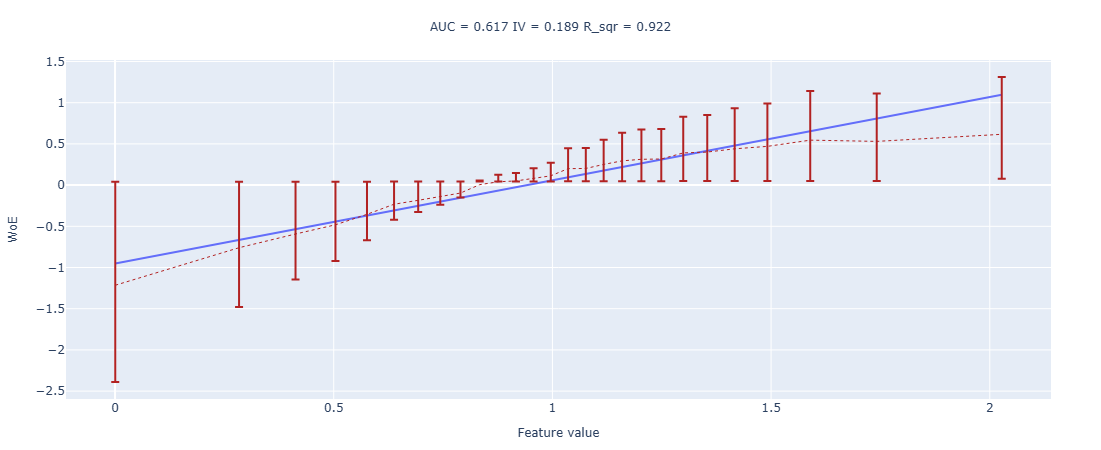

In [108]:
woe_line(np.array(df_for_logreg_selected[df_for_logreg_selected.sample_part.isin(['train', 'validation'])]['logit_logreg']), df_for_logreg_selected[df_for_logreg_selected.sample_part.isin(['train', 'validation'])].target, n**(1/3)/3)

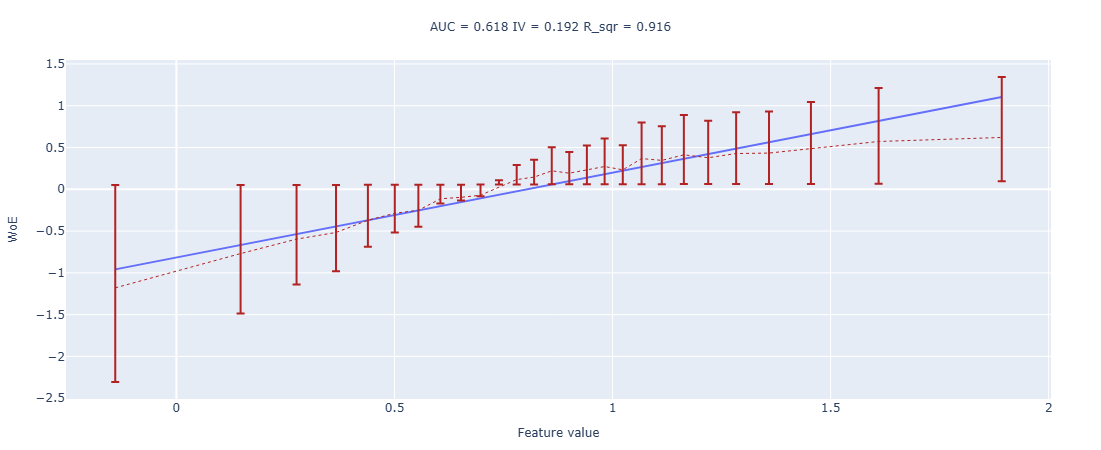

In [109]:
woe_line(np.array(df_for_logreg_selected[df_for_logreg_selected.sample_part == 'test']['logit_logreg']), df_for_logreg_selected[df_for_logreg_selected.sample_part == 'test'].target, n**(1/3)/3)

Видно, что модель особенно не линейна на высоких рисках.

In [111]:
df_for_logreg_selected = df_for_logreg_selected.merge(df.quarter, left_index=True, right_index=True)

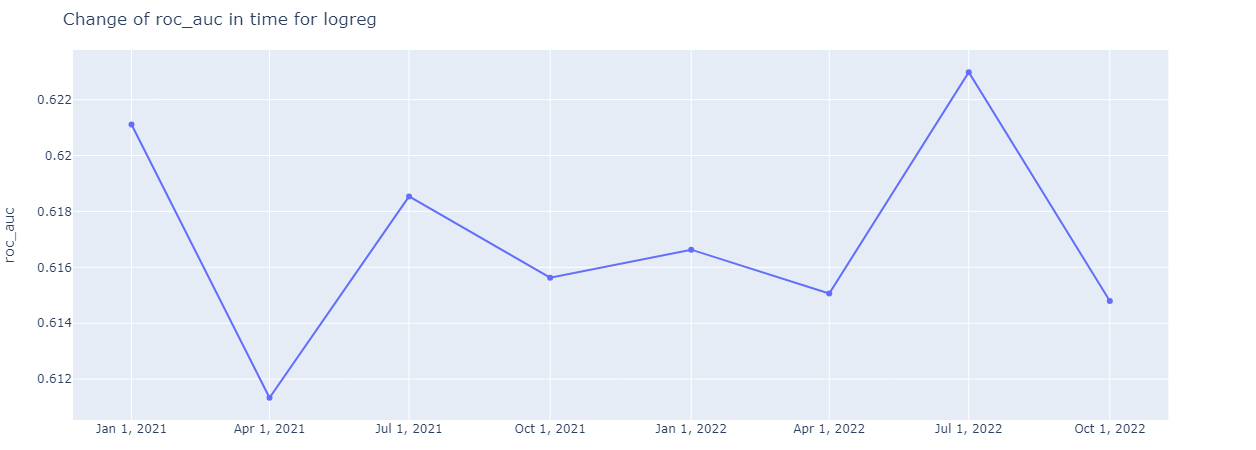

In [112]:
plot_metric_time(df_for_logreg_selected.logreg, df_for_logreg_selected['target'], df_for_logreg_selected['quarter'], metric='roc_auc')

Визуализируем важность фичей полученной линейной модели.

<BarContainer object of 65 artists>

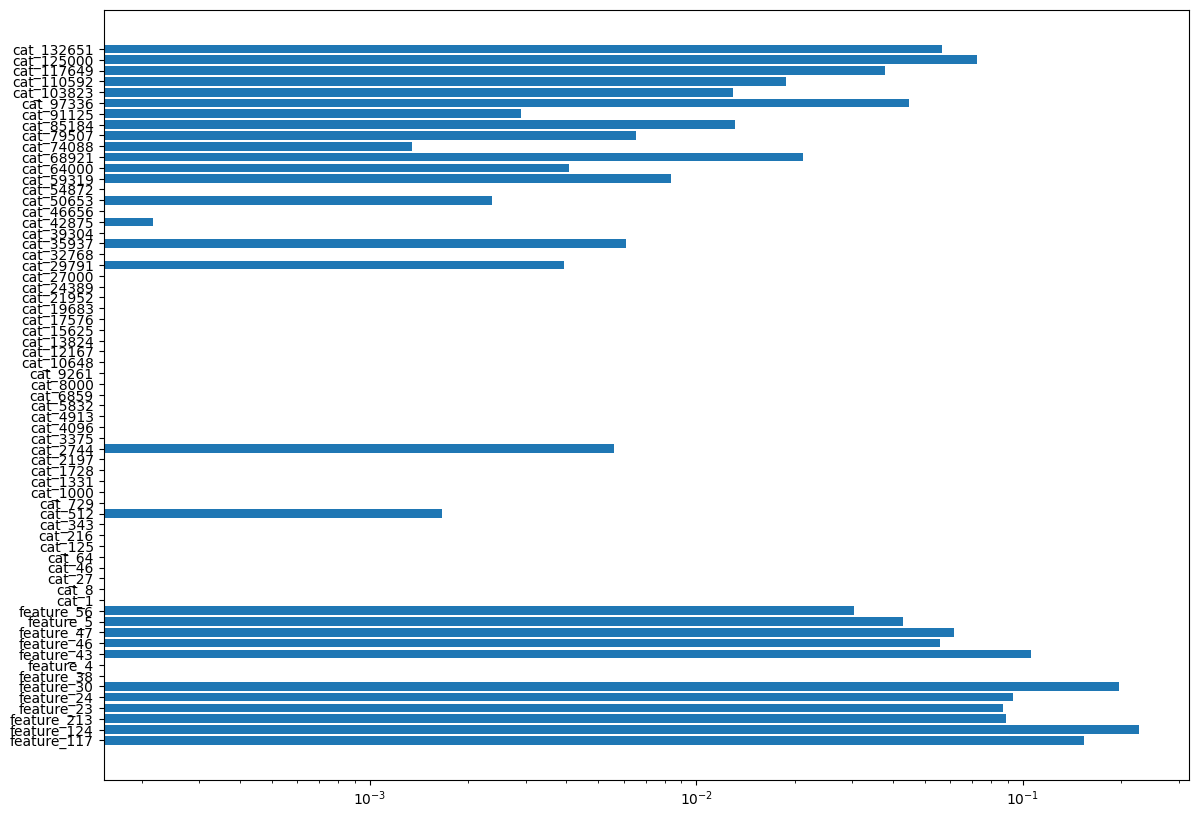

In [110]:
plt.figure(figsize=(14, 10))
plt.barh(df_for_logreg_no_date.drop(['target', 'sample_part', 'logreg', 'logit_logreg'], axis=1).columns, logreg.coef_[0], log=True, height=0.8)

In [111]:
# видно, что много фичей не пригодилось

In [112]:
# test = df_for_logreg_no_date.drop(['target', 'sample_part'], axis=1).columns[logreg.coef_[0] > 10**(-4)]
# но и без них лучше не стало, видимо некоторые хорошо работают в каких-то определенных подмножествах.

# Другие способы отбора признаков

Беру фичи после отбора по IV.

In [113]:
good_features = good_int_features.append(good_float_features)
good_features.shape

(54,)

https://scikit-learn.org/stable/modules/feature_selection.html

In [114]:
from sklearn.feature_selection import RFE

In [131]:
estimator = LGBMClassifier()
selector = RFE(estimator, n_features_to_select=36, step=1)
X = df.dropna()[good_features].to_numpy()
y = df.dropna().target.to_numpy()
selector = selector.fit(X, y)

[LightGBM] [Info] Number of positive: 206383, number of negative: 78129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11545
[LightGBM] [Info] Number of data points in the train set: 284512, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.725393 -> initscore=0.971372
[LightGBM] [Info] Start training from score 0.971372
[LightGBM] [Info] Number of positive: 206383, number of negative: 78129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11543
[LightGBM] [Info] Number of data points in the train set: 284512, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.725393 -> initscore=0.971372
[LightGBM] [Info] Start training from score 0.971372
[LightGBM]

In [132]:
features_optuna = good_features[selector.support_]
features_optuna

Index(['feature_140', 'feature_109', 'feature_111', 'feature_115',
       'feature_117', 'feature_124', 'feature_132', 'feature_164',
       'feature_170', 'feature_172', 'feature_183', 'feature_206',
       'feature_213', 'feature_216', 'feature_223', 'feature_225',
       'feature_227', 'feature_23', 'feature_24', 'feature_26', 'feature_30',
       'feature_39', 'feature_4', 'feature_43', 'feature_44', 'feature_46',
       'feature_47', 'feature_5', 'feature_56', 'feature_75', 'feature_76',
       'feature_79', 'feature_9', 'feature_94', 'feature_96', 'feature_98'],
      dtype='object')

In [133]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=False),
        'num_leaves': trial.suggest_int('num_leaves', 250, 325),
        # 'importance_type': ['split', 'gain'],
        'objective': 'binary',
        'random_state': 42
    }
    
    clf = LGBMClassifier(**params)
    clf.fit(
        X=df.loc[df['sample_part'] == 'train', features_optuna],
        y=df.loc[df['sample_part'] == 'train', TARGET]
    )
    preds = clf.predict_proba(df.loc[df['sample_part'] == 'val', features_optuna])[:, 1]
    auc_valid = roc_auc_score(
        y_true=df.loc[df['sample_part'] == 'val', TARGET],
        y_score=preds
    )
    
    return auc_valid

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=True)

In [135]:
print(study.best_params)

{'learning_rate': 0.07364228922835167, 'num_leaves': 310}


In [136]:
clf = LGBMClassifier(**study.best_params)
clf.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET]
)

preds_test = clf.predict_proba(df.loc[df['sample_part'] == 'test', features_optuna])[:, 1]
auc_test = roc_auc_score(
    y_true=df.loc[df['sample_part'] == 'test', TARGET],
    y_score=preds_test
)
print(auc_test)

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8978
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
0.7308117340927199


In [138]:
# 40 фичей - скор 0.734
# 35 фичей - скор 0.729
# 30 фичей - скор 0.723
# 15 - 0.66
# 38 - 0.732
# 42 - 0.738
# 43 - 0.731
# 36 - 0.731

Удалось оставить 42 фичи из 54 с сохранением качества модели.
(Можно даже 36, если не важны десятые доли процента)